In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from geopy.distance import geodesic
import folium
import math
import io
import json

In [ ]:
# Foi feita a média de 10 coletas estáticas no centro de rotação do pivô com o esp32 e ficou um pouco distante o circulo de referência. 
# Usarei valores do centro do pivô fornecidas pelo professor
# lat_medida = -22,7134209
# long_medida = -47,6284572

# lat_professor = -22.7132778 --- > 22°42'48,17276'' S
# long_professor = -47.6291389 ---> 47°37'42,84343'' W

# Coordenadas para posicionar o mapa do folium no pivô
pivot_lat = -22.7133813
pivot_long = -47.6285677

# Pontos Referência Pivô

In [6]:
# Dados do novo centro
radius_m = 10.23  # raio do círculo em metros
num_points = 720

# Constantes de conversão
meters_per_degree_lat = 111320  # metros por grau latitude
meters_per_degree_lon = meters_per_degree_lat * math.cos(math.radians(pivot_lat))  # metros por grau longitude ajustado

# Lista para armazenar os pontos do novo círculo
circle_points_pivot = []

for i in range(num_points):
    angle_deg = i * (360/num_points)
    angle_rad = math.radians(angle_deg)

    delta_lat = (radius_m * math.cos(angle_rad)) / meters_per_degree_lat
    delta_lon = (radius_m * math.sin(angle_rad)) / meters_per_degree_lon

    new_lat = pivot_lat + delta_lat
    new_lon = pivot_long + delta_lon

    circle_points_pivot.append({"latitude": new_lat, "longitude": new_lon, "angle_deg": angle_deg})

# Criar DataFrame e salvar como CSV
df_pivot_circle = pd.DataFrame(circle_points_pivot)
df_pivot_circle.to_csv("Dados/pontos_referencia_pivo.csv", index=False)

In [8]:
# Carregando as coordenadas projetadas no utilizando o centro do pivo
df_pivot = pd.read_csv('Dados/pontos_referencia_pivo.csv')
df_pivot

,latitude,longitude,angle_deg
0,-22.713289,-47.628568,0.0
1,-22.713289,-47.628567,0.5
2,-22.713289,-47.628566,1.0
3,-22.713289,-47.628565,1.5
4,-22.713289,-47.628564,2.0
...,...,...,...
715,-22.713289,-47.628572,357.5
716,-22.713289,-47.628571,358.0
717,-22.713289,-47.628570,358.5
718,-22.713289,-47.628569,359.0


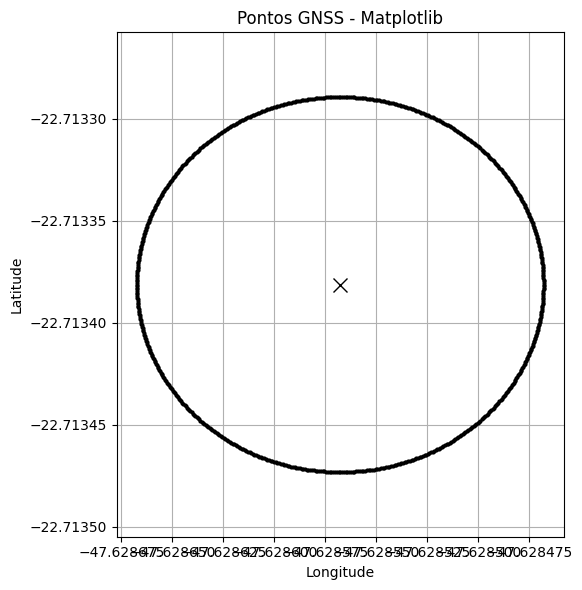

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(df_pivot["longitude"], df_pivot["latitude"], marker='o', linestyle="", markersize=2, color='black')
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=10, label='Ponto de Pivô')
ax.set_title("Pontos GNSS - Matplotlib")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()


In [10]:
# Adiciona os pontos como marcadores circulares
# Criar o mapa centralizado na sua coordenada
map_reference = folium.Map(location=[pivot_lat, pivot_long], zoom_start=14)

for _, row in df_pivot.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=2,
        color="black",
        fill=True,
        fill_opacity=0.7,
        popup=f'Ângulo: {row["angle_deg"]}°'
    ).add_to(map_reference)

folium.CircleMarker(
    location=[pivot_lat, pivot_long],
    radius=2,
    color="black",
    fill=True,
    fill_opacity=0.7,
    popup=f'Ângulo: {row["angle_deg"]}°'
).add_to(map_reference)

# Salva o mapa em HTML
map_reference.save("mapa_pivo_referencia.html")

# Ensaios Realizados

Os ensaios estão organizados da seguinte forma:

- ❌ Volta 1: 12,5 Hz (o esp32 não coletou por conta de problemas na rede de energia, nos proximos foi usado um powerbank)   --> 23/04/25 11:28 até 12:38
- ✅ Volta 2: 12,5 Hz (todos os equipamentos coletaram)   --> 23/04/25 15:51 até 17:01
- ❌ Volta 3: 12,5 Hz (o app SW Maps não coletou)         --> 24/04/25 14:55 até 16:05
- ✅ Volta 4: 25 Hz (todos os equipamentos coletaram)     --> 25/04/25 9:20 até 10:30
- ✅ Volta 5: 25 Hz (todos os equipamentos coletaram)     --> 25/04/25 10:50 até 12:00


- ✅ Volta 6: 25 Hz (todos os equipamentos coletaram)     --> 25/04/25 12:25 até 13:35
- ✅ Volta 7: 12,5 Hz (todos os equipamentos coletaram)   --> 25/04/25 13:58 até 15:08
- ✅ Volta 8: 12,5 Hz (todos os equipamentos coletaram)   --> 25/04/25 15:50 até 17:00

12,5 Hz no inversor corresponde a 2,5 m/s
25 Hz no inversor corresponde a 5 m/s

Foram feitas coletas pontuais antes da volta 4, contudo o método utilizado para coleta foi de 1:10h de coleta e 20m de pausa para dar tempo de mudar a constelação dos satélites. A volta 2 irá compor a volta faltante para a situação de 12,5 HZ.

Os dados foram coletados a cada 5 segundos (0,2Hz).

In [11]:
'''
Como houveram ensaios que nem todos os dispositivos conseguiram coletar, vou organizar da seguinte forma:

 - lap_1 = Volta 4 (25Hz - 5m/s)
 - lap_2 = Volta 5 (25Hz - 5m/s)
 - lap_3 = Volta 6 (25Hz - 5m/s)
 - lap_4 = Volta 7 (12,5Hz - 2,5m/s)
 - lap_5 = Volta 8 (12,5Hz - 2,5m/s)
 - lap_6 = Volta 2 (12,5Hz - 2,5m/s)

'''

laps = {
    "lap_1": {
        "lap_start": "2025-04-25 09:20",
        "lap_end": "2025-04-25 10:30",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
    "lap_2": {
        "lap_start": "2025-04-25 10:50",
        "lap_end": "2025-04-25 12:00",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
    "lap_3": {
        "lap_start": "2025-04-25 12:25",
        "lap_end": "2025-04-25 13:35",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
    "lap_4": {
        "lap_start": "2025-04-25 13:58",
        "lap_end": "2025-04-25 15:08",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
    "lap_5": {
        "lap_start": "2025-04-25 15:50",
        "lap_end": "2025-04-25 17:00",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
    "lap_6": {
        "lap_start": "2025-04-23 15:51",
        "lap_end": "2025-04-23 17:01",
        "esp32": {},
        "celular": {},
        "garmin": {}
    },
}

In [12]:
'''
A estrtura que se busca montar é conforme o exemplo abaixo:


laps = {
    "volta_1": {
        "lap_start": "2025-04-25 09:20",
        "lap_end": "2025-04-25 10:30",
        "esp32": {
            "dataframe": df_esp32_volta_1,  # DataFrame com dados tratados do ESP32
            "erro_analysis": {
                "media_erro_m": 1.23,
                "desvio_erro_m": 0.45,
                "2sigma_m": 0.90,
                "max_erro_m": 2.56,
                "min_erro_m": 0.11,
                "qtd_pontos": 85,
                "erros_metros": [1.1, 1.3, 1.0, ...]
            }
        },
        "celular": {
            "dataframe": df_celular_volta_1,
            "erro_analysis": {
                "media_erro_m": 2.34,
                "desvio_erro_m": 0.78,
                "2sigma_m": 1.56,
                "max_erro_m": 3.45,
                "min_erro_m": 0.89,
                "qtd_pontos": 90,
                "erros_metros": [2.0, 2.5, 2.1, ...]
            }
        },
        "garmin": {
            "dataframe": df_garmin_volta_1,
            "erro_analysis": {
                "media_erro_m": 0.97,
                "desvio_erro_m": 0.32,
                "2sigma_m": 0.64,
                "max_erro_m": 1.50,
                "min_erro_m": 0.50,
                "qtd_pontos": 92,
                "erros_metros": [0.8, 1.1, 1.0, ...]
            }
        }
    },
    "volta_2": {
        "lap_start": "2025-04-25 10:50",
        "lap_end": "2025-04-25 12:00",
        "esp32": {
            "dataframe": ...,
            "erro_analysis": {...}
        },
        "celular": {
            "dataframe": ...,
            "erro_analysis": {...}
        },
        "garmin": {
            "dataframe": ...,
            "erro_analysis": {...}
        }
    },
    ...
}
'''

'\nA estrtura que se busca montar é conforme o exemplo abaixo:\n\n\nlaps = {\n    "volta_1": {\n        "lap_start": "2025-04-25 09:20",\n        "lap_end": "2025-04-25 10:30",\n        "esp32": {\n            "dataframe": df_esp32_volta_1,  # DataFrame com dados tratados do ESP32\n            "erro_analysis": {\n                "media_erro_m": 1.23,\n                "desvio_erro_m": 0.45,\n                "2sigma_m": 0.90,\n                "max_erro_m": 2.56,\n                "min_erro_m": 0.11,\n                "qtd_pontos": 85,\n                "erros_metros": [1.1, 1.3, 1.0, ...]\n            }\n        },\n        "celular": {\n            "dataframe": df_celular_volta_1,\n            "erro_analysis": {\n                "media_erro_m": 2.34,\n                "desvio_erro_m": 0.78,\n                "2sigma_m": 1.56,\n                "max_erro_m": 3.45,\n                "min_erro_m": 0.89,\n                "qtd_pontos": 90,\n                "erros_metros": [2.0, 2.5, 2.1, ...]\n    

## ESP32

In [13]:

df_esp_250_1 = pd.read_csv('Dados/esp32_volta_4.csv') # 25Hz inversor = 2,5ms - lap_1
df_esp_250_2 = pd.read_csv('Dados/esp32_volta_5.csv') # 25Hz inversor = 2,5ms - lap_2
df_esp_250_3 = pd.read_csv('Dados/esp32_volta_6.csv') # 25Hz inversor = 2,5ms - lap_3

df_esp_125_1 = pd.read_csv('Dados/esp32_volta_7.csv') # 12,5Hz inversor = 2,5ms - lap_4
df_esp_125_2 = pd.read_csv('Dados/esp32_volta_8.csv') # 12,5Hz inversor = 2,5ms - lap_5
df_esp_125_3 = pd.read_csv('Dados/esp32_volta_2.csv') # 12,5Hz inversor = 2,5ms - lap_6


laps["lap_1"]["esp32"]["dataframe"] = df_esp_250_1
laps["lap_2"]["esp32"]["dataframe"] = df_esp_250_2
laps["lap_3"]["esp32"]["dataframe"] = df_esp_250_3
laps["lap_4"]["esp32"]["dataframe"] = df_esp_125_1
laps["lap_5"]["esp32"]["dataframe"] = df_esp_125_2
laps["lap_6"]["esp32"]["dataframe"] = df_esp_125_3

laps["lap_6"]["esp32"]["dataframe"]


,2025-04-23 15:54:15,2025-4-23 18:54:15,-22.713407,-47.628441,543.300000,0.87,10
0,2025-04-23 15:54:17,2025-4-23 18:54:16,-22.713423,-47.628442,543.2,0.87,10
1,2025-04-23 15:54:18,2025-4-23 18:54:17,-22.713440,-47.628447,543.1,0.87,10
2,2025-04-23 15:54:19,2025-4-23 18:54:19,-22.713468,-47.628464,543.1,0.87,10
3,2025-04-23 15:54:20,2025-4-23 18:54:20,-22.713479,-47.628477,543.4,0.87,10
4,2025-04-23 15:54:21,2025-4-23 18:54:21,-22.713489,-47.628491,543.4,0.87,10
...,...,...,...,...,...,...,...
3292,2025-04-23 16:54:10,2025-4-23 19:54:10,-22.713385,-47.628626,546.8,1.18,9
3293,2025-04-23 16:54:11,2025-4-23 19:54:11,-22.713372,-47.628616,546.9,0.93,10
3294,2025-04-23 16:54:12,2025-4-23 19:54:12,-22.713360,-47.628603,547.0,0.93,10
3295,2025-04-23 16:54:13,2025-4-23 19:54:13,-22.713351,-47.628588,546.9,0.93,10


In [14]:
# Percorrendo as chaves do dicionário, estou renomeando as colunas, cortando os dados capturados fora do range de lap_start e lap_end e
# diminuindo a frequência de coleta, pois o esp32 eu configurei para coletar a cada 1 seg e selecionei dados a cada 5 seg

for lap_name, lap_data in laps.items():
    # Verifica se há dados em esp32 e se "dataframe" está presente
    if "dataframe" in lap_data.get("esp32", {}):
        dataframe = lap_data["esp32"]["dataframe"]

        # Renomeia as colunas
        dataframe.columns = ['timestamp_net', 'timestamp_gps', 'latitude', 'longitude', 'altitude', 'hdop', 'satélites']
        
        # Converte a coluna 'timestamp_net' para datetime
        dataframe['timestamp_net'] = pd.to_datetime(dataframe['timestamp_net'])
        
        # Usa o lap_start e lap_end da volta como timestamps e tirando os 5 primeiros e os 5 últimos minutos
        start_time = pd.Timestamp(lap_data["lap_start"]) + pd.Timedelta(minutes=5)
        end_time = pd.Timestamp(lap_data["lap_end"]) - pd.Timedelta(minutes=5)
        
        # Filtra os dados dentro do intervalo de tempo da volta
        dataframe = dataframe[
            (dataframe['timestamp_net'] >= start_time) &
            (dataframe['timestamp_net'] <= end_time)
        ]
        
        # Ordena por timestamp e reseta o índice
        dataframe = dataframe.sort_values('timestamp_net').reset_index(drop=True)
        
        # Seleciona linhas com múltiplos de 5 segundos exatos a partir do start_time
        dataframe = dataframe[((dataframe['timestamp_net'] - start_time).dt.total_seconds() % 5 == 0)]
        
        # Atualiza o dataframe tratado no dicionário
        laps[lap_name]["esp32"]["dataframe"] = dataframe



In [15]:
laps["lap_1"]["esp32"]["dataframe"]

,timestamp_net,timestamp_gps,latitude,longitude,altitude,hdop,satélites
0,2025-04-25 09:25:00,2025-4-25 12:25:0,-22.713293,-47.628612,547.5,1.13,10
5,2025-04-25 09:25:05,2025-4-25 12:25:5,-22.713366,-47.628478,547.6,0.91,10
9,2025-04-25 09:25:10,2025-4-25 12:25:10,-22.713470,-47.628592,547.1,0.91,10
14,2025-04-25 09:25:15,2025-4-25 12:25:15,-22.713342,-47.628664,547.8,0.82,11
19,2025-04-25 09:25:20,2025-4-25 12:25:20,-22.713310,-47.628510,547.7,0.91,10
...,...,...,...,...,...,...,...
3288,2025-04-25 10:24:35,2025-4-25 13:24:35,-22.713426,-47.628667,549.6,0.85,10
3293,2025-04-25 10:24:40,2025-4-25 13:24:40,-22.713290,-47.628611,549.1,0.85,10
3302,2025-04-25 10:24:50,2025-4-25 13:24:50,-22.713464,-47.628607,549.7,0.95,9
3307,2025-04-25 10:24:55,2025-4-25 13:24:55,-22.713330,-47.628670,549.8,0.85,10


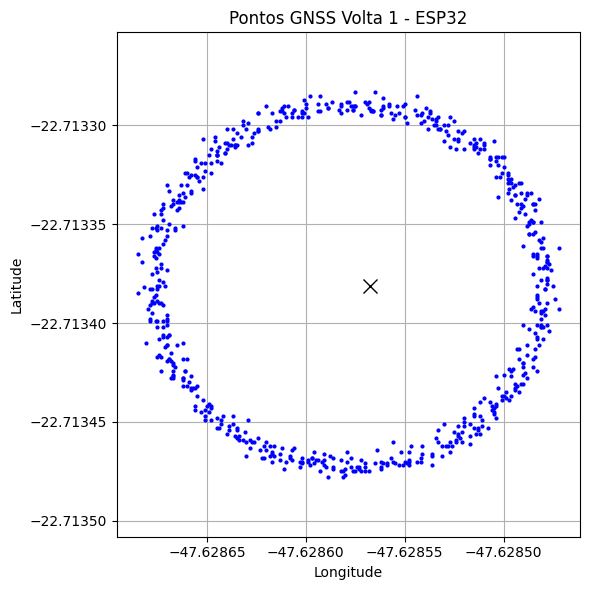

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot( laps['lap_1']["esp32"]["dataframe"]["longitude"], laps['lap_1']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue')
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=10, label='Ponto de Pivô')
ax.set_title("Pontos GNSS Volta 1 - ESP32")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()


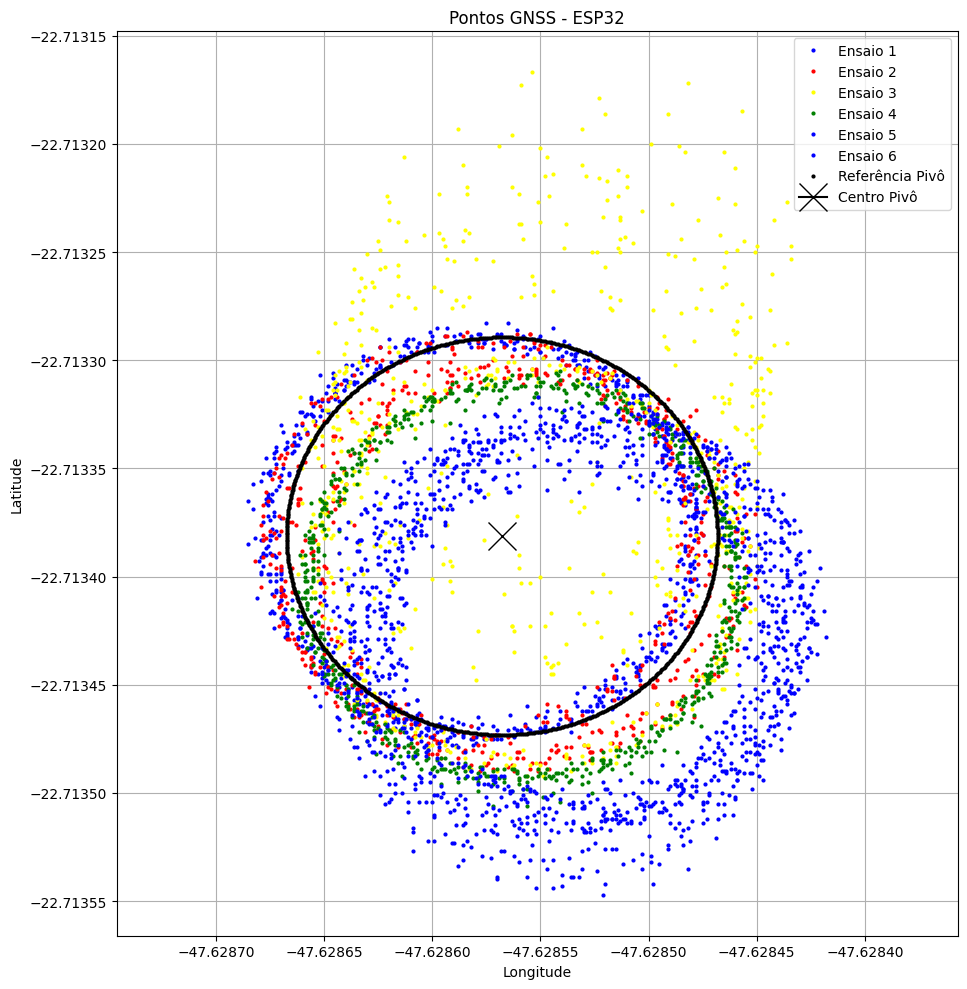

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot( laps['lap_1']["esp32"]["dataframe"]["longitude"], laps['lap_1']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 1")
ax.plot( laps['lap_2']["esp32"]["dataframe"]["longitude"], laps['lap_2']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='red', label="Ensaio 2")
ax.plot( laps['lap_3']["esp32"]["dataframe"]["longitude"], laps['lap_3']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='yellow', label="Ensaio 3")
ax.plot( laps['lap_4']["esp32"]["dataframe"]["longitude"], laps['lap_4']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='green', label="Ensaio 4")
ax.plot( laps['lap_5']["esp32"]["dataframe"]["longitude"], laps['lap_5']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 5")
ax.plot( laps['lap_6']["esp32"]["dataframe"]["longitude"], laps['lap_6']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 6")
ax.plot(df_pivot["longitude"], df_pivot["latitude"], marker='o', linestyle="", markersize=2, color='black', label="Referência Pivô")
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=20, label="Centro Pivô")

ax.legend()

ax.set_title("Pontos GNSS - ESP32")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()

In [18]:
# Primeiro, criar o mapa centralizado no seu pivô
map_esp32 = folium.Map(location=[pivot_lat, pivot_long], zoom_start=17, tiles="OpenStreetMap")

# Definindo as voltas, cores e nomes
laps_to_plot = ['lap_1', 'lap_2', 'lap_3', 'lap_4', 'lap_5', 'lap_6']
colors = ['blue', 'red', 'yellow', 'green', 'purple', 'orange']
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

# Adiciona os pontos de cada volta
for lap_name, color, label in zip(laps_to_plot, colors, labels):
    df_esp = laps[lap_name]["esp32"].get("dataframe")
    if df_esp is not None:
        for _, row in df_esp.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=2,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f"{label}"
            ).add_to(map_esp32)

# Adiciona os pontos de referência do pivô
for _, row in df_pivot.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        popup="Referência Pivô"
    ).add_to(map_esp32)

# Adiciona o centro do pivô
folium.Marker(
    location=[pivot_lat, pivot_long],
    icon=folium.Icon(color='black', icon='star'),
    popup="Centro Pivô"
).add_to(map_esp32)

# Salva o mapa
map_esp32.save("mapa_esp32.html")

### Erro Mínima Distância Geodésica

Esse método de cálculo de erro analisa a menor distância geodésica de cada ponto para o ponto mais próximo da referência do pivô

In [19]:
for lap_name in laps.keys():
    lap_df = laps[lap_name]["esp32"].get("dataframe")
    if lap_df is None or lap_df.empty:
        continue

    euclidean_errors = []
    north_south_errors = []
    east_west_errors = []

    for _, lap_point in lap_df.iterrows():
        test_point = (lap_point['latitude'], lap_point['longitude'])

        # Calcula a distância geodésica para todos os pontos de referência
        distances = [
            geodesic(test_point, (row['latitude'], row['longitude'])).meters
            for _, row in df_pivot.iterrows()
        ]

        # Identifica o ponto de referência mais próximo
        idx_min = np.argmin(distances)
        ref_point = df_pivot.iloc[idx_min]

        # Diferença de coordenadas
        delta_lat = lap_point['latitude'] - ref_point['latitude']
        delta_lon = lap_point['longitude'] - ref_point['longitude']

        # Converte diferença em metros
        delta_ns = delta_lat * 111320  # metros por grau de latitude
        avg_lat = (lap_point['latitude'] + ref_point['latitude']) / 2
        delta_ew = delta_lon * 111320 * np.cos(np.radians(avg_lat))  # metros por grau de longitude

        # Armazena erros
        euclidean_errors.append(distances[idx_min])
        north_south_errors.append(delta_ns)
        east_west_errors.append(delta_ew)

    # Calcula estatísticas
    mean_euclidean_error = np.mean(euclidean_errors)
    mean_ns_error = np.mean(north_south_errors)
    mean_ew_error = np.mean(east_west_errors)

    std_euclidean_error = np.std(euclidean_errors)
    std_ns_error = np.std(north_south_errors)
    std_ew_error = np.std(east_west_errors)

    max_euclidean_error = np.max(euclidean_errors)
    max_ns_error = np.max(north_south_errors)
    max_ew_error = np.max(east_west_errors)

    min_euclidean_error = np.min(euclidean_errors)
    min_ns_error = np.min(north_south_errors)
    min_ew_error = np.min(east_west_errors)

    two_sigma = 2 * std_euclidean_error

    # Calcula o erro circular provável (CEP)
    cep = 1.18 * math.sqrt(std_ns_error**2 + std_ew_error**2)

    # Armazena no dicionário laps
    laps[lap_name]["esp32"]["error_analysis"] = {
        'mean_euclidean_error_m': mean_euclidean_error,
        'mean_ns_error_m': mean_ns_error,
        'mean_ew_error_m': mean_ew_error,
        'std_euclidean_error_m': std_euclidean_error,
        'std_ns_error_m': std_ns_error,
        'std_ew_error_m': std_ew_error,
        '2sigma_m': two_sigma,
        'cep_m': cep,
        'max_euclidean_error_m': max_euclidean_error,
        'max_ns_error_m': max_ns_error,
        'max_ew_error_m': max_ew_error,
        'min_euclidean_error_m': min_euclidean_error,
        'min_ns_error_m': min_ns_error,
        'min_ew_error_m': min_ew_error,
        'num_points': len(euclidean_errors),
        'euclidean_errors_m': euclidean_errors,
        'north_south_errors_m': north_south_errors,
        'east_west_errors_m': east_west_errors
    }

for lap_name in laps.keys():
    if "esp32" in laps[lap_name] and "error_analysis" in laps[lap_name]["esp32"]:
        res = laps[lap_name]["esp32"]["error_analysis"]
        print(f"\n{lap_name}:")
        print(f"  ➔ Erro médio (m): {res['mean_euclidean_error_m']:.2f}")
        print(f"  ➔ Desvio padrão (m): {res['std_euclidean_error_m']:.2f}")
        print(f"  ➔ 2σ (m): {res['2sigma_m']:.2f}")
        print(f"  ➔ Erro máximo (m): {res['max_euclidean_error_m']:.2f}")
        print(f"  ➔ Erro mínimo (m): {res['min_euclidean_error_m']:.2f}")
        print(f"  ➔ Quantidade de pontos: {res['num_points']}")
        print(f"  ➔ Média do erro N-S (m): {res['mean_ns_error_m']:.2f}")
        print(f"  ➔ Desvio padrão N-S (m): {res['std_ns_error_m']:.2f}")
        print(f"  ➔ Máximo N-S (m): {res['max_ns_error_m']:.2f}")
        print(f"  ➔ Mínimo N-S (m): {res['min_ns_error_m']:.2f}")
        print(f"  ➔ Média do erro E-W (m): {res['mean_ew_error_m']:.2f}")
        print(f"  ➔ Desvio padrão E-W (m): {res['std_ew_error_m']:.2f}")
        print(f"  ➔ Máximo E-W (m): {res['max_ew_error_m']:.2f}")
        print(f"  ➔ Mínimo E-W (m): {res['min_ew_error_m']:.2f}")
        print(f"  ➔ CEP (m): {res['cep_m']:.2f}")


lap_1:
  ➔ Erro médio (m): 0.70
  ➔ Desvio padrão (m): 0.44
  ➔ 2σ (m): 0.89
  ➔ Erro máximo (m): 1.96
  ➔ Erro mínimo (m): 0.01
  ➔ Quantidade de pontos: 670
  ➔ Média do erro N-S (m): 0.02
  ➔ Desvio padrão N-S (m): 0.46
  ➔ Máximo N-S (m): 1.40
  ➔ Mínimo N-S (m): -1.21
  ➔ Média do erro E-W (m): -0.52
  ➔ Desvio padrão E-W (m): 0.46
  ➔ Máximo E-W (m): 0.28
  ➔ Mínimo E-W (m): -1.93
  ➔ CEP (m): 0.77

lap_2:
  ➔ Erro médio (m): 1.01
  ➔ Desvio padrão (m): 0.61
  ➔ 2σ (m): 1.21
  ➔ Erro máximo (m): 3.19
  ➔ Erro mínimo (m): 0.01
  ➔ Quantidade de pontos: 661
  ➔ Média do erro N-S (m): -0.48
  ➔ Desvio padrão N-S (m): 0.71
  ➔ Máximo N-S (m): 1.42
  ➔ Mínimo N-S (m): -2.45
  ➔ Média do erro E-W (m): -0.00
  ➔ Desvio padrão E-W (m): 0.82
  ➔ Máximo E-W (m): 3.18
  ➔ Mínimo E-W (m): -1.92
  ➔ CEP (m): 1.28

lap_3:
  ➔ Erro médio (m): 2.96
  ➔ Desvio padrão (m): 2.74
  ➔ 2σ (m): 5.48
  ➔ Erro máximo (m): 14.61
  ➔ Erro mínimo (m): 0.01
  ➔ Quantidade de pontos: 702
  ➔ Média do erro N-

In [21]:
# Código apenas para estruturar as informações dos erros e mostrar de maneira organizada
error_data = []

# Define os rótulos das voltas
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

for i, lap_name in enumerate(laps.keys()):
    # Acessa as métricas de erro do ESP32
    error_analysis = laps[lap_name]['esp32']['error_analysis']
    
    error_data.append({
        'Ensaio': labels[i],

        'EMP': error_analysis['mean_euclidean_error_m'],
        'EM/L-O': error_analysis['mean_ew_error_m'],
        'EM/N-S': error_analysis['mean_ns_error_m'],


        'DP': error_analysis['std_euclidean_error_m'],
        'DP/L-O': error_analysis['std_ew_error_m'],
        'DP/N-S': error_analysis['std_ns_error_m'],

        '2σ': error_analysis['2sigma_m'],
        'CEP': error_analysis['cep_m'],
        
        'Max Error': error_analysis['max_euclidean_error_m'],
        'Min Error': error_analysis['min_euclidean_error_m'],
        
        'Num Points': error_analysis['num_points']
    })

# Cria o DataFrame
df_error_esp32 = pd.DataFrame(error_data)

df_error_esp32


,Ensaio,EMP,EM/L-O,EM/N-S,DP,DP/L-O,DP/N-S,2σ,CEP,Max Error,Min Error,Num Points
0,Ensaio 1,0.704255,-0.520441,0.023532,0.442714,0.457981,0.461032,0.885428,0.766816,1.955565,0.011333,670
1,Ensaio 2,1.013991,-0.001905,-0.475790,0.606715,0.822922,0.706806,1.213430,1.280055,3.193256,0.013024,661
2,Ensaio 3,2.963005,0.794413,1.231890,2.739949,2.041239,3.176047,5.479897,4.455016,14.609905,0.007959,702
3,Ensaio 4,1.629747,0.469845,-1.176422,0.851267,0.942589,0.954085,1.702535,1.582587,3.878876,0.007381,702
4,Ensaio 5,4.037759,1.454600,-2.622635,2.157005,2.423300,2.493575,4.314010,4.102990,8.997813,0.045646,707
5,Ensaio 6,3.446039,1.756283,-1.857004,1.792803,2.035099,2.118976,3.585606,3.466808,6.820359,0.005333,632


In [22]:
# Parâmetros para Criação dos Gráficos
num_laps = len(laps)
cols = 3
rows = int(np.ceil(num_laps / cols))

lap_names = list(laps.keys())
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']  # ajuste conforme necessário

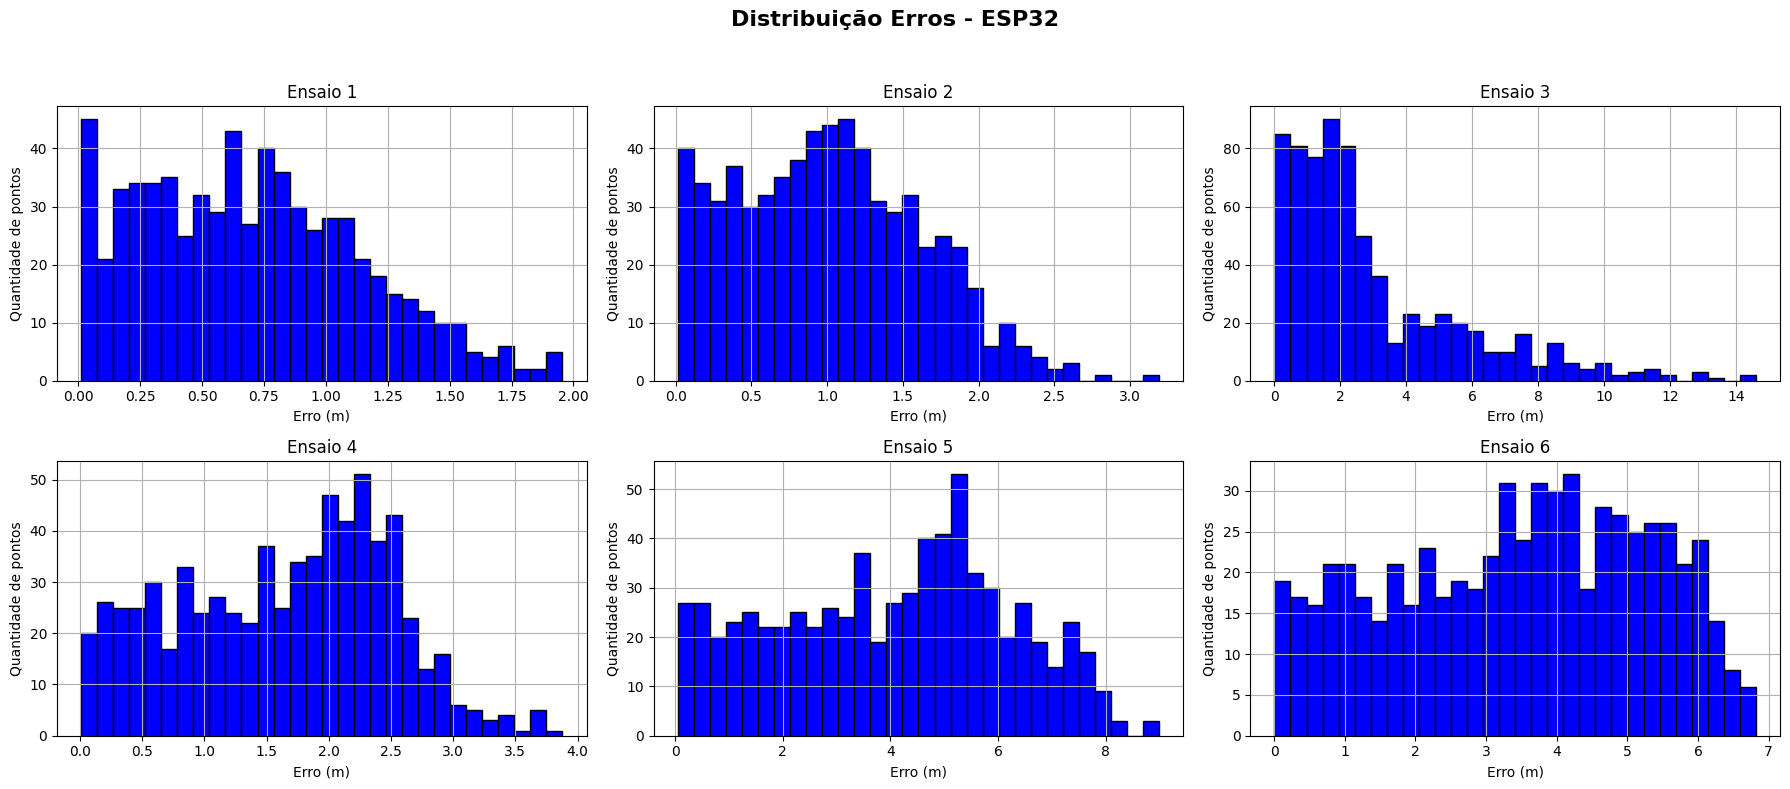

In [23]:
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Adiciona título geral antes dos subplots
fig.suptitle('Distribuição Erros - ESP32', fontsize=16, fontweight='bold')

for i, lap_name in enumerate(laps.keys()):
    erros = laps[lap_name]['esp32']['error_analysis']['euclidean_errors_m']
    
    axs[i].hist(erros, bins=30, color='blue', edgecolor='black')
    axs[i].set_title(f'{labels[i]}')
    axs[i].set_xlabel('Erro (m)')
    axs[i].set_ylabel('Quantidade de pontos')
    axs[i].grid(True)

# Oculta eixos extras se houver
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Ajusta o layout e reposiciona para não sobrepor o título
plt.tight_layout(rect=[0, 0, 1, 0.95])  # reserve espaço para o suptitle
plt.show()


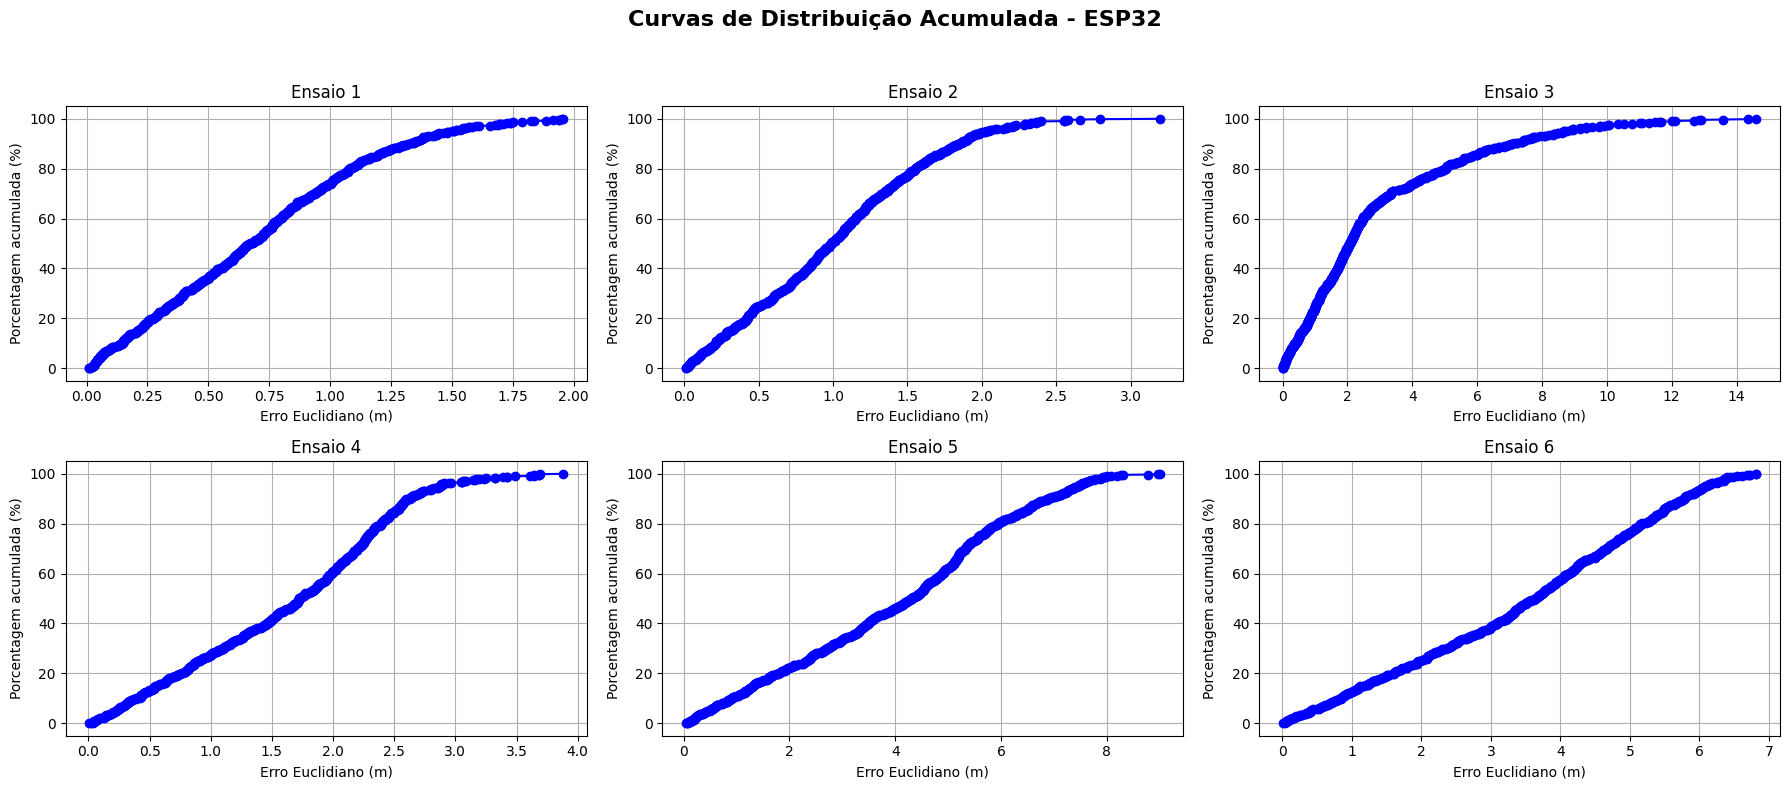

In [24]:
# Cria os subplots
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Título geral
fig.suptitle('Curvas de Distribuição Acumulada - ESP32', fontsize=16, fontweight='bold')

for i, lap_name in enumerate(laps.keys()):
    # Erros euclidianos do ensaio atual
    errors = np.array(laps[lap_name]['esp32']['error_analysis']['euclidean_errors_m'])

    # Ordena os erros
    sorted_errors = np.sort(errors)

    # Calcula as porcentagens acumuladas
    percentages = np.linspace(0, 100, len(sorted_errors))

    # Plota a curva de distribuição acumulada
    axs[i].plot(sorted_errors, percentages, marker='o', linestyle='-', color='blue')
    axs[i].set_title(f'{labels[i]}')
    axs[i].set_xlabel('Erro Euclidiano (m)')
    axs[i].set_ylabel('Porcentagem acumulada (%)')
    axs[i].grid(True)

# Desativa os eixos vazios (caso o número de subplots exceda o número de laps)
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Ajusta o layout para não sobrepor o título
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


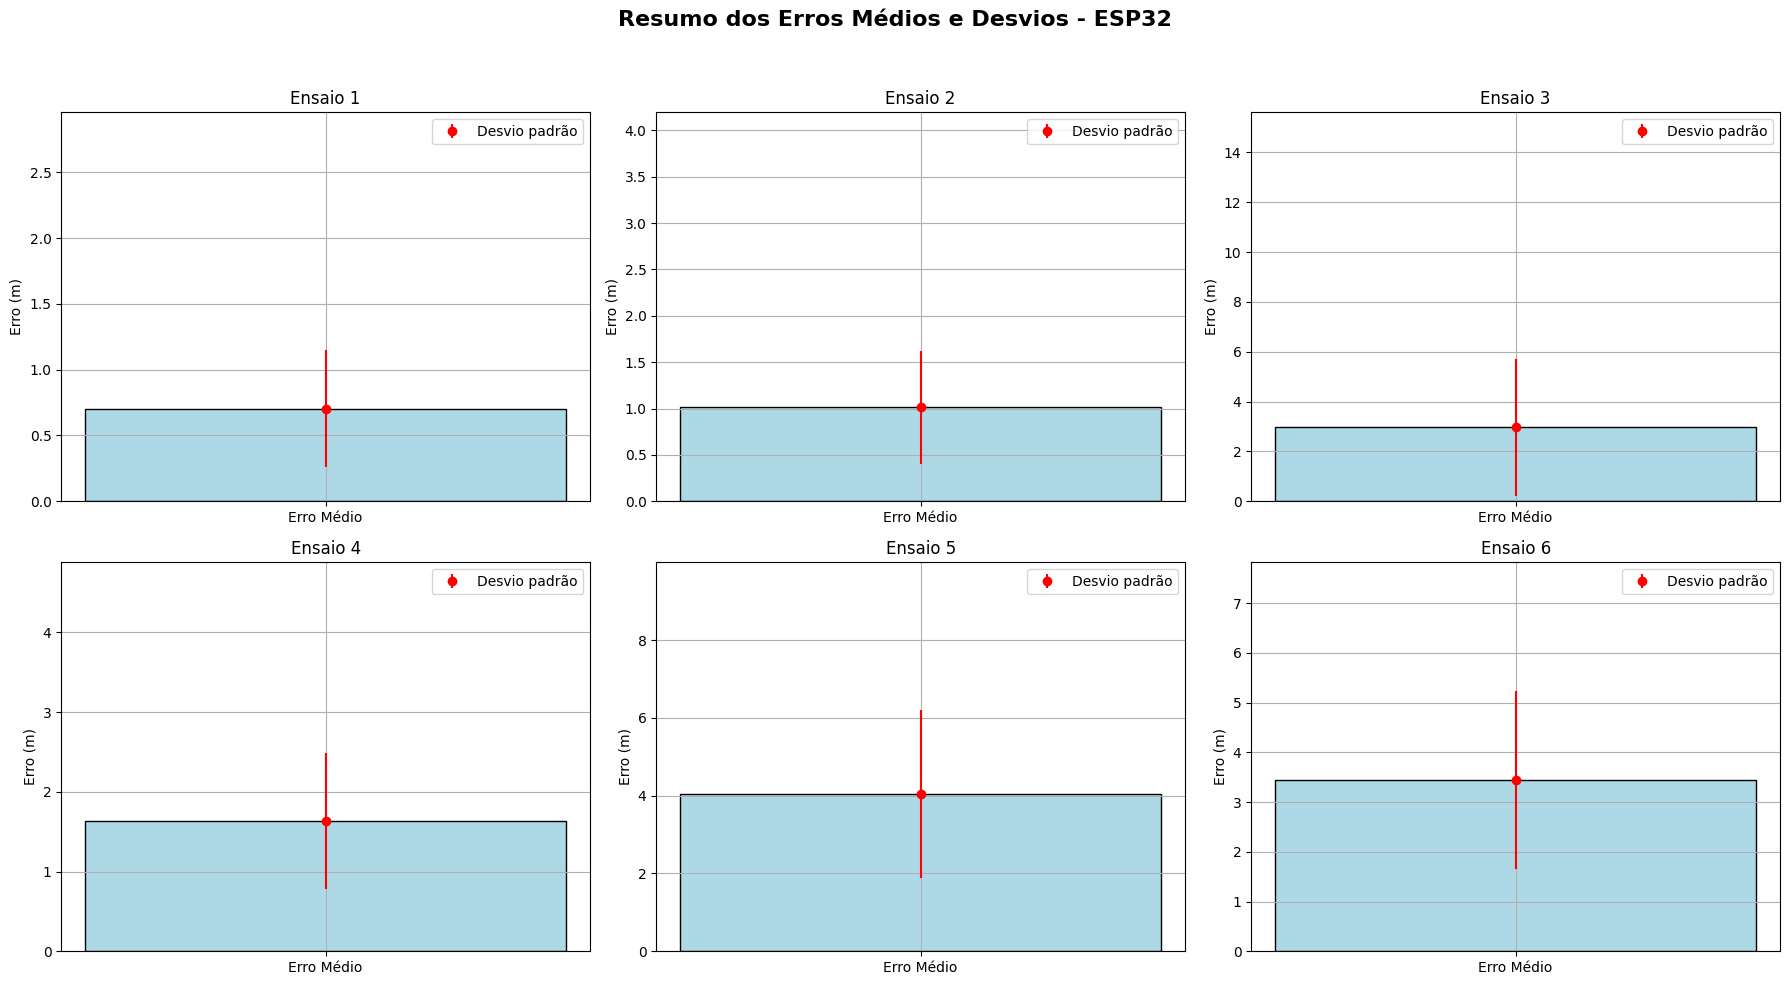

In [25]:
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axs = axs.flatten()

# Título geral
fig.suptitle('Resumo dos Erros Médios e Desvios - ESP32', fontsize=16, fontweight='bold')

for i, lap_name in enumerate(lap_names):
    analysis = laps[lap_name]['esp32']['error_analysis']
    mean_error = analysis['mean_euclidean_error_m']
    std_error = analysis['std_euclidean_error_m']
    max_error = analysis['max_euclidean_error_m']

    # Barra para erro médio
    axs[i].bar(['Erro Médio'], [mean_error], color='lightblue', edgecolor='black')

    # Linha de erro (desvio padrão)
    axs[i].errorbar('Erro Médio', mean_error, yerr=std_error, fmt='o', color='red', label='Desvio padrão')

    # Ajuste do eixo Y
    axs[i].set_ylim(0, max_error + 1)
    axs[i].set_title(f'{labels[i]}')
    axs[i].set_ylabel('Erro (m)')
    axs[i].legend()
    axs[i].grid(True)

# Oculta subplots não utilizados
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # reserva espaço para o título
plt.show()


### Erro Mínima Distância + Ângulo

Esse erro parece mais correto pois se eu tiver um deslocamento do meu circulo e ele fizer a intersecção na referência, a intersecção será o menor valor. O correto seria tentar pelo grau que aquele ponto se encontra baseado no seu ponto central que forma o circulo para os dados

In [26]:
def calcular_angulo(ponto, centro):
    delta_x = ponto[1] - centro[1]  # longitude
    delta_y = ponto[0] - centro[0]  # latitude
    angulo_rad = np.arctan2(delta_y, delta_x)
    angulo_deg = np.degrees(angulo_rad) % 360
    return angulo_deg

# Faz uma cópia da referência e calcula o ângulo dela uma única vez
ref = df_pivot.copy()
centro = (pivot_lat, pivot_long)  # Referência de latitude e longitude do centro
ref['angulo'] = ref.apply(
    lambda row: calcular_angulo((row['latitude'], row['longitude']), centro),
    axis=1
)

# Loop sobre cada volta
for lap_name in laps.keys():
    esp = laps[lap_name]["esp32"].get("dataframe")
    if esp is None or esp.empty:
        continue

    erros_metros = []
    erros_ns = []
    erros_ew = []

    for _, ponto in esp.iterrows():
        ponto_ensaio = (ponto['latitude'], ponto['longitude'])
        angulo_ensaio = calcular_angulo(ponto_ensaio, centro)

        # Encontra o índice do ponto de referência com o ângulo mais próximo
        idx_ref = (ref['angulo'] - angulo_ensaio).abs().idxmin()
        ponto_ref = (ref.loc[idx_ref, 'latitude'], ref.loc[idx_ref, 'longitude'])

        # Calcula a distância geodésica
        erro_metro = geodesic(ponto_ensaio, ponto_ref).meters
        erros_metros.append(erro_metro)

        # Calcula as diferenças de latitude e longitude para N-S e E-W
        delta_lat = ponto_ensaio[0] - ponto_ref[0]
        delta_lon = ponto_ensaio[1] - ponto_ref[1]

        # Conversão para metros
        delta_ns = delta_lat * 111320  # Aproximadamente metros por grau de latitude
        lat_media = (ponto_ensaio[0] + ponto_ref[0]) / 2
        delta_ew = delta_lon * 111320 * np.cos(np.radians(lat_media))  # Aproximadamente metros por grau de longitude

        # Armazena os erros N-S e E-W
        erros_ns.append(delta_ns)
        erros_ew.append(delta_ew)

    # Calcula as estatísticas de erro
    media_erro = np.mean(erros_metros)
    desvio_erro = np.std(erros_metros)
    max_erro = np.max(erros_metros)
    min_erro = np.min(erros_metros)
    dois_sigma = 2 * desvio_erro

    # Calcula estatísticas para N-S e E-W
    media_ns_erro = np.mean(erros_ns)
    desvio_ns_erro = np.std(erros_ns)
    max_ns_erro = np.max(erros_ns)
    min_ns_erro = np.min(erros_ns)

    media_ew_erro = np.mean(erros_ew)
    desvio_ew_erro = np.std(erros_ew)
    max_ew_erro = np.max(erros_ew)
    min_ew_erro = np.min(erros_ew)

    # Armazenamento dos resultados na estrutura de dados
    laps[lap_name]["esp32"]["erro_analysis_angle"] = {
        'media_erro_m': media_erro,
        'desvio_erro_m': desvio_erro,
        '2sigma_m': dois_sigma,
        'max_erro_m': max_erro,
        'min_erro_m': min_erro,
        'qtd_pontos': len(erros_metros),
        'erros_metros': erros_metros,
        'media_ns_erro_m': media_ns_erro,
        'desvio_ns_erro_m': desvio_ns_erro,
        'max_ns_erro_m': max_ns_erro,
        'min_ns_erro_m': min_ns_erro,
        'erros_ns_m': erros_ns,
        'media_ew_erro_m': media_ew_erro,
        'desvio_ew_erro_m': desvio_ew_erro,
        'max_ew_erro_m': max_ew_erro,
        'min_ew_erro_m': min_ew_erro,
        'erros_ew_m': erros_ew
    }

# Exibe o resumo dos resultados
for lap_name in laps.keys():
    ana = laps[lap_name]["esp32"].get("erro_analysis_angle")
    if not ana:
        continue
    print(f"\n{lap_name} (ESP32, erro por ângulo):")
    print(f"  ➔ Erro médio (m): {ana['media_erro_m']:.2f}")
    print(f"  ➔ Desvio padrão (m): {ana['desvio_erro_m']:.2f}")
    print(f"  ➔ 2σ (m): {ana['2sigma_m']:.2f}")
    print(f"  ➔ Erro máximo (m): {ana['max_erro_m']:.2f}")
    print(f"  ➔ Erro mínimo (m): {ana['min_erro_m']:.2f}")
    print(f"  ➔ Pontos avaliados: {ana['qtd_pontos']}")
    print(f"  ➔ Média do erro N-S (m): {ana['media_ns_erro_m']:.2f}")
    print(f"  ➔ Desvio padrão N-S (m): {ana['desvio_ns_erro_m']:.2f}")
    print(f"  ➔ Máximo N-S (m): {ana['max_ns_erro_m']:.2f}")
    print(f"  ➔ Mínimo N-S (m): {ana['min_ns_erro_m']:.2f}")
    print(f"  ➔ Média do erro E-W (m): {ana['media_ew_erro_m']:.2f}")
    print(f"  ➔ Desvio padrão E-W (m): {ana['desvio_ew_erro_m']:.2f}")
    print(f"  ➔ Máximo E-W (m): {ana['max_ew_erro_m']:.2f}")
    print(f"  ➔ Mínimo E-W (m): {ana['min_ew_erro_m']:.2f}")



lap_1 (ESP32, erro por ângulo):
  ➔ Erro médio (m): 0.70
  ➔ Desvio padrão (m): 0.44
  ➔ 2σ (m): 0.89
  ➔ Erro máximo (m): 1.96
  ➔ Erro mínimo (m): 0.01
  ➔ Pontos avaliados: 670
  ➔ Média do erro N-S (m): 0.02
  ➔ Desvio padrão N-S (m): 0.46
  ➔ Máximo N-S (m): 1.40
  ➔ Mínimo N-S (m): -1.21
  ➔ Média do erro E-W (m): -0.52
  ➔ Desvio padrão E-W (m): 0.46
  ➔ Máximo E-W (m): 0.28
  ➔ Mínimo E-W (m): -1.93

lap_2 (ESP32, erro por ângulo):
  ➔ Erro médio (m): 1.01
  ➔ Desvio padrão (m): 0.61
  ➔ 2σ (m): 1.21
  ➔ Erro máximo (m): 3.19
  ➔ Erro mínimo (m): 0.01
  ➔ Pontos avaliados: 661
  ➔ Média do erro N-S (m): -0.47
  ➔ Desvio padrão N-S (m): 0.70
  ➔ Máximo N-S (m): 1.42
  ➔ Mínimo N-S (m): -2.45
  ➔ Média do erro E-W (m): -0.00
  ➔ Desvio padrão E-W (m): 0.83
  ➔ Máximo E-W (m): 3.18
  ➔ Mínimo E-W (m): -1.92

lap_3 (ESP32, erro por ângulo):
  ➔ Erro médio (m): 2.96
  ➔ Desvio padrão (m): 2.74
  ➔ 2σ (m): 5.48
  ➔ Erro máximo (m): 14.61
  ➔ Erro mínimo (m): 0.01
  ➔ Pontos avaliado

## Celular

In [27]:
df_celular_250_1 = pd.read_excel('Dados/celular_volta_4.xlsx') # 25Hz inversor = 2,5ms - lap_1
df_celular_250_2 = pd.read_excel('Dados/celular_volta_5.xlsx') # 25Hz inversor = 2,5ms - lap_2
df_celular_250_3 = pd.read_excel('Dados/celular_volta_6.xlsx') # 25Hz inversor = 2,5ms - lap_3

df_celular_125_1 = pd.read_excel('Dados/celular_volta_7.xlsx') # 12,5Hz inversor = 2,5ms - lap_4
df_celular_125_2 = pd.read_excel('Dados/celular_volta_8.xlsx') # 12,5Hz inversor = 2,5ms - lap_5
df_celular_125_3 = pd.read_excel('Dados/celular_volta_2.xlsx') # 12,5Hz inversor = 2,5ms - lap_6


laps["lap_1"]["celular"]["dataframe"] = df_celular_250_1
laps["lap_2"]["celular"]["dataframe"] = df_celular_250_2
laps["lap_3"]["celular"]["dataframe"] = df_celular_250_3
laps["lap_4"]["celular"]["dataframe"] = df_celular_125_1
laps["lap_5"]["celular"]["dataframe"] = df_celular_125_2
laps["lap_6"]["celular"]["dataframe"] = df_celular_125_3

laps["lap_6"]["celular"]["dataframe"]

,Track Name,Time,Geometry,Lat,Lon,X,Y,Elevation,Ortho Height,Instrument Ht,Fix ID,Speed,Bearing,Horizontal Accuracy,Vertical Accuracy,PDOP,HDOP,VDOP,Satellites in View,Satellites in Use
0,volta 4,04/23/2025 15:49:15.000 GMT-03:00,"POINT Z (-47,628639033 -22,713400617 542,300)",-22713400617,-47628639033,229980751.0,7.485813e+09,542.3,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,26,21
1,volta 4,04/23/2025 15:49:20.000 GMT-03:00,"POINT Z (-47,628639333 -22,713399817 543,100)",-22713399817,-47628639333,229980719.0,7.485813e+09,543.1,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,29,23
2,volta 4,04/23/2025 15:49:25.000 GMT-03:00,"POINT Z (-47,628639050 -22,713400100 543,400)",-227134001,-4762863905,229980748.0,7.485813e+09,543.4,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,30,24
3,volta 4,04/23/2025 15:49:30.000 GMT-03:00,"POINT Z (-47,628639250 -22,713399983 543,500)",-22713399983,-4762863925,229980727.0,7.485813e+09,543.5,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,31,24
4,volta 4,04/23/2025 15:49:35.000 GMT-03:00,"POINT Z (-47,628638933 -22,713400583 543,400)",-22713400583,-47628638933,229980761.0,7.485813e+06,543.4,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,30,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,volta 4,04/23/2025 17:01:55.000 GMT-03:00,"POINT Z (-47,628634133 -22,713472800 545,000)",-227134728,-47628634133,229981396.0,7.485805e+09,545.0,0,0,1,0.772,328.4,3.79,2.5,0,0,0,30,25
873,volta 4,04/23/2025 17:02:00.000 GMT-03:00,"POINT Z (-47,628645533 -22,713441117 545,600)",-22713441117,-47628645533,229980162.0,7.485809e+09,545.6,0,0,1,0.720,329.2,3.79,2.5,0,0,0,29,25
874,volta 4,04/23/2025 17:02:05.000 GMT-03:00,"POINT Z (-47,628642033 -22,713404833 546,100)",-22713404833,-47628642033,229980451.0,7.485813e+09,546.1,0,0,1,0.772,358.6,3.79,2.5,0,0,0,30,24
875,volta 4,04/23/2025 17:02:10.000 GMT-03:00,"POINT Z (-47,628633383 -22,713388983 546,100)",-22713388983,-47628633383,229981309.0,7.485815e+09,546.1,0,0,1,0.000,-1.0,3.79,2.5,0,0,0,29,25


In [28]:
# Função para limpar e formatar as coordenadas, pois o celular fornece a string meio estranha, como: -22485693359 ao invés de -22.485693359
def clean_coord(val):
    try:
        if pd.isna(val):
            return None
        val = str(val).replace('.', '')  # Remove todos os pontos
        if len(val) < 3:
            return None  # Muito curto pra ser coordenada válida
        return float(val[:3] + '.' + val[3:])  # Ex: "22713333" → 22.713333
    except Exception:
        return None

# Percorrendo as chaves do dicionário, cortando os dados capturados fora do range de lap_start e lap_end e manipulando a string para
# ela fica no padrão de -22.12412 pois atualmente não tem um ponto dividindo
for lap_name, lap_data in laps.items():
    
    df_cel = lap_data.get("celular", {}).get("dataframe")
    if df_cel is None or df_cel.empty:
        continue

    # Converte a coluna 'Time' para datetime e localiza no fuso de SP
    df_cel['Time'] = pd.to_datetime(df_cel['Time'])

    # Cria timestamps de início e fim já com fuso e tirando os 5 primeiros e os 5 últimos minutos
    start_time = pd.Timestamp(lap_data["lap_start"]).tz_localize("America/Sao_Paulo") + pd.Timedelta(minutes=5)
    end_time   = pd.Timestamp(lap_data["lap_end"]).tz_localize("America/Sao_Paulo") - pd.Timedelta(minutes=5)


    # Filtra pelo intervalo da volta
    df_cel = df_cel[(df_cel['Time'] >= start_time) & (df_cel['Time'] <= end_time)]

    # Ordena e reseta índice
    df_cel = df_cel.sort_values('Time').reset_index(drop=True)

    # Limpa as coordenadas brutas
    df_cel['Lat'] = df_cel['Lat'].apply(clean_coord)
    df_cel['Lon'] = df_cel['Lon'].apply(clean_coord)

    df_cel.rename(columns={'Lat': 'latitude', 'Lon': 'longitude'}, inplace=True)

    # Reatribui o DataFrame tratado ao dicionário
    laps[lap_name]["celular"]["dataframe"] = df_cel

In [29]:
laps["lap_6"]["celular"]["dataframe"]

,Track Name,Time,Geometry,latitude,longitude,X,Y,Elevation,Ortho Height,Instrument Ht,Fix ID,Speed,Bearing,Horizontal Accuracy,Vertical Accuracy,PDOP,HDOP,VDOP,Satellites in View,Satellites in Use
0,volta 4,2025-04-23 15:56:00-03:00,"POINT Z (-47,628444167 -22,713450733 542,500)",-22.713451,-47.628444,230000876.0,7.485808e+06,542.5,0,0,1,1903.0,197.8,3.79,2.5,0,0,0,31,25
1,volta 4,2025-04-23 15:56:05-03:00,"POINT Z (-47,628518667 -22,713506317 542,700)",-22.713506,-47.628519,229993329.0,7.485802e+09,542.7,0,0,1,1903.0,250.4,3.79,2.5,0,0,0,31,26
2,volta 4,2025-04-23 15:56:10-03:00,"POINT Z (-47,628611833 -22,713485017 542,900)",-22.713485,-47.628612,229983712.0,7.485804e+09,542.9,0,0,1,1955.0,303.6,3.79,2.5,0,0,0,31,26
3,volta 4,2025-04-23 15:56:15-03:00,"POINT Z (-47,628649450 -22,713402950 543,400)",-22.713403,-47.628649,229979685.0,7.485813e+09,543.4,0,0,1,1903.0,356.7,3.79,2.5,0,0,0,31,27
4,volta 4,2025-04-23 15:56:20-03:00,"POINT Z (-47,628600567 -22,713325867 543,900)",-22.713326,-47.628601,229984557.0,7.485822e+09,543.9,0,0,1,1903.0,49.4,3.79,2.5,0,0,0,31,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,volta 4,2025-04-23 16:55:40-03:00,"POINT Z (-47,628526183 -22,713518667 543,300)",-22.713519,-47.628526,229992581.0,7.485800e+09,543.3,0,0,1,1955.0,251.0,3.79,2.5,0,0,0,29,23
717,volta 4,2025-04-23 16:55:45-03:00,"POINT Z (-47,628617517 -22,713495867 543,200)",-22.713496,-47.628618,229983149.0,7.485803e+09,543.2,0,0,1,1903.0,303.8,3.79,2.5,0,0,0,28,22
718,volta 4,2025-04-23 16:55:50-03:00,"POINT Z (-47,628655833 -22,713415917 543,700)",-22.713416,-47.628656,229979054.0,7.485812e+09,543.7,0,0,1,1903.0,356.7,3.79,2.5,0,0,0,29,24
719,volta 4,2025-04-23 16:55:55-03:00,"POINT Z (-47,628606050 -22,713338617 543,900)",-22.713339,-47.628606,229984019.0,7.485820e+09,543.9,0,0,1,1903.0,49.6,3.79,2.5,0,0,0,30,23


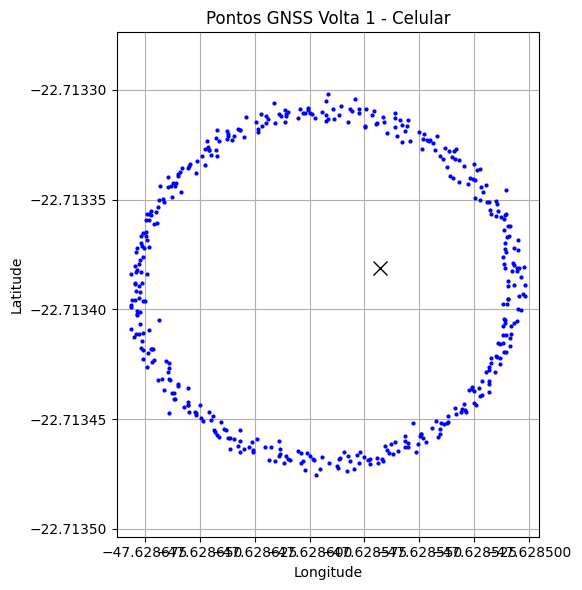

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(laps['lap_1']["celular"]["dataframe"]["longitude"], laps['lap_1']["celular"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue')
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=10, label='Ponto de Pivô')
ax.set_title("Pontos GNSS Volta 1 - Celular")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()

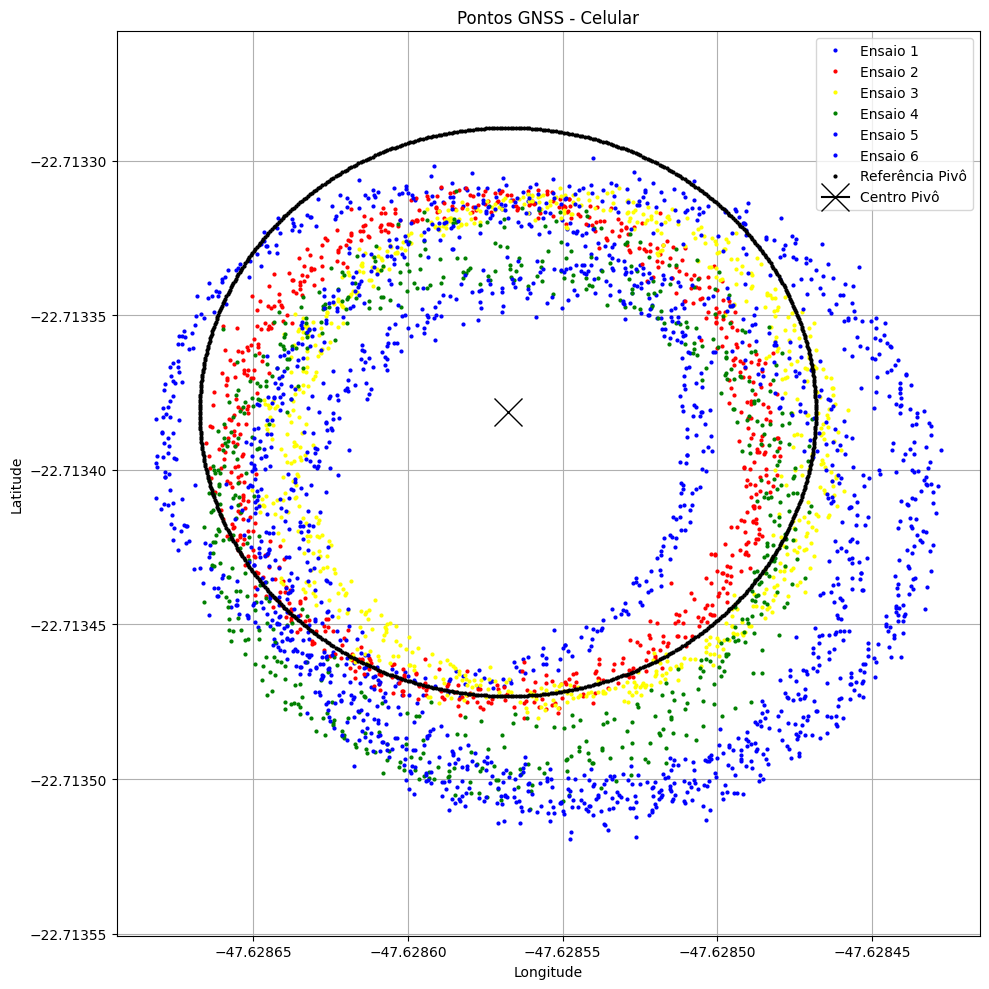

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot( laps['lap_1']["celular"]["dataframe"]["longitude"], laps['lap_1']["celular"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 1")
ax.plot( laps['lap_2']["celular"]["dataframe"]["longitude"], laps['lap_2']["celular"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='red', label="Ensaio 2")
ax.plot( laps['lap_3']["celular"]["dataframe"]["longitude"], laps['lap_3']["celular"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='yellow', label="Ensaio 3")
ax.plot( laps['lap_4']["celular"]["dataframe"]["longitude"], laps['lap_4']["celular"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='green', label="Ensaio 4")
ax.plot( laps['lap_5']["celular"]["dataframe"]["longitude"], laps['lap_5']["celular"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 5")
ax.plot( laps['lap_6']["celular"]["dataframe"]["longitude"], laps['lap_6']["celular"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 6")
ax.plot(df_pivot["longitude"], df_pivot["latitude"], marker='o', linestyle="", markersize=2, color='black', label="Referência Pivô")
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=20, label="Centro Pivô")

ax.legend()

ax.set_title("Pontos GNSS - Celular")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()

In [32]:
# Primeiro, criar o mapa centralizado no seu pivô
map_celular = folium.Map(location=[pivot_lat, pivot_long], zoom_start=17, tiles="OpenStreetMap")

# Definindo as voltas, cores e nomes
laps_to_plot = ['lap_1', 'lap_2', 'lap_3', 'lap_4', 'lap_5', 'lap_6']
colors = ['blue', 'red', 'yellow', 'green', 'purple', 'orange']
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

# Adiciona os pontos de cada volta
for lap_name, color, label in zip(laps_to_plot, colors, labels):
    if "celular" in laps[lap_name] and "dataframe" in laps[lap_name]["celular"]:
        df = laps[lap_name]["celular"]["dataframe"]
        for _, row in df.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=2,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f"{label}"
            ).add_to(map_celular)

# Adiciona os pontos de referência do pivô
for _, row in df_pivot.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        popup="Referência Pivô"
    ).add_to(map_celular)

# Adiciona o centro do pivô
folium.Marker(
    location=[pivot_lat, pivot_long],
    icon=folium.Icon(color='black', icon='star'),
    popup="Centro Pivô"
).add_to(map_celular)

# Salva o mapa
map_celular.save("mapa_celular.html")


### Erro Mínima Distância Geodésica

Esse método de cálculo de erro analisa a menor distância geodésica de cada ponto para o ponto mais próximo da referência do pivô

In [33]:
for lap_name in laps.keys():
    lap_df = laps[lap_name]["celular"].get("dataframe")
    if lap_df is None or lap_df.empty:
        continue

    euclidean_errors = []
    north_south_errors = []
    east_west_errors = []

    for _, lap_point in lap_df.iterrows():
        test_point = (lap_point['latitude'], lap_point['longitude'])

        # Calcula a distância geodésica para todos os pontos de referência
        distances = [
            geodesic(test_point, (row['latitude'], row['longitude'])).meters
            for _, row in df_pivot.iterrows()
        ]

        # Identifica o ponto de referência mais próximo
        idx_min = np.argmin(distances)
        ref_point = df_pivot.iloc[idx_min]

        # Diferença de coordenadas
        delta_lat = lap_point['latitude'] - ref_point['latitude']
        delta_lon = lap_point['longitude'] - ref_point['longitude']

        # Converte diferença em metros
        delta_ns = delta_lat * 111320  # metros por grau de Lat
        avg_lat = (lap_point['latitude'] + ref_point['latitude']) / 2
        delta_ew = delta_lon * 111320 * np.cos(np.radians(avg_lat))  # metros por grau de Lon

        # Armazena erros
        euclidean_errors.append(distances[idx_min])
        north_south_errors.append(delta_ns)
        east_west_errors.append(delta_ew)

    # Calcula estatísticas
    mean_euclidean_error = np.mean(euclidean_errors)
    mean_ns_error = np.mean(north_south_errors)
    mean_ew_error = np.mean(east_west_errors)

    std_euclidean_error = np.std(euclidean_errors)
    std_ns_error = np.std(north_south_errors)
    std_ew_error = np.std(east_west_errors)

    max_euclidean_error = np.max(euclidean_errors)
    max_ns_error = np.max(north_south_errors)
    max_ew_error = np.max(east_west_errors)

    min_euclidean_error = np.min(euclidean_errors)
    min_ns_error = np.min(north_south_errors)
    min_ew_error = np.min(east_west_errors)

    two_sigma = 2 * std_euclidean_error

    # Calcula o erro circular provável (CEP)
    cep = 1.18 * math.sqrt(std_ns_error**2 + std_ew_error**2)

    # Armazena no dicionário laps
    laps[lap_name]["celular"]["error_analysis"] = {
        'mean_euclidean_error_m': mean_euclidean_error,
        'mean_ns_error_m': mean_ns_error,
        'mean_ew_error_m': mean_ew_error,
        'std_euclidean_error_m': std_euclidean_error,
        'std_ns_error_m': std_ns_error,
        'std_ew_error_m': std_ew_error,
        '2sigma_m': two_sigma,
        'cep_m': cep,
        'max_euclidean_error_m': max_euclidean_error,
        'max_ns_error_m': max_ns_error,
        'max_ew_error_m': max_ew_error,
        'min_euclidean_error_m': min_euclidean_error,
        'min_ns_error_m': min_ns_error,
        'min_ew_error_m': min_ew_error,
        'num_points': len(euclidean_errors),
        'euclidean_errors_m': euclidean_errors,
        'north_south_errors_m': north_south_errors,
        'east_west_errors_m': east_west_errors
    }

# Exibe os resultados
for lap_name in laps.keys():
    if "celular" in laps[lap_name] and "error_analysis" in laps[lap_name]["celular"]:
        res = laps[lap_name]["celular"]["error_analysis"]
        print(f"\n{lap_name}:")
        print(f"  ➔ Erro médio (m): {res['mean_euclidean_error_m']:.2f}")
        print(f"  ➔ Desvio padrão (m): {res['std_euclidean_error_m']:.2f}")
        print(f"  ➔ 2σ (m): {res['2sigma_m']:.2f}")
        print(f"  ➔ Erro máximo (m): {res['max_euclidean_error_m']:.2f}")
        print(f"  ➔ Erro mínimo (m): {res['min_euclidean_error_m']:.2f}")
        print(f"  ➔ Quantidade de pontos: {res['num_points']}")
        print(f"  ➔ Média do erro N-S (m): {res['mean_ns_error_m']:.2f}")
        print(f"  ➔ Desvio padrão N-S (m): {res['std_ns_error_m']:.2f}")
        print(f"  ➔ Máximo N-S (m): {res['max_ns_error_m']:.2f}")
        print(f"  ➔ Mínimo N-S (m): {res['min_ns_error_m']:.2f}")
        print(f"  ➔ Média do erro E-W (m): {res['mean_ew_error_m']:.2f}")
        print(f"  ➔ Desvio padrão E-W (m): {res['std_ew_error_m']:.2f}")
        print(f"  ➔ Máximo E-W (m): {res['max_ew_error_m']:.2f}")
        print(f"  ➔ Mínimo E-W (m): {res['min_ew_error_m']:.2f}")
        print(f"  ➔ CEP (m): {res['cep_m']:.2f}")


lap_1:
  ➔ Erro médio (m): 1.83
  ➔ Desvio padrão (m): 1.31
  ➔ 2σ (m): 2.63
  ➔ Erro máximo (m): 4.54
  ➔ Erro mínimo (m): 0.01
  ➔ Quantidade de pontos: 432
  ➔ Média do erro N-S (m): -0.39
  ➔ Desvio padrão N-S (m): 1.44
  ➔ Máximo N-S (m): 2.34
  ➔ Mínimo N-S (m): -3.73
  ➔ Média do erro E-W (m): -1.06
  ➔ Desvio padrão E-W (m): 1.33
  ➔ Máximo E-W (m): 0.79
  ➔ Mínimo E-W (m): -4.46
  ➔ CEP (m): 2.31

lap_2:
  ➔ Erro médio (m): 1.34
  ➔ Desvio padrão (m): 0.95
  ➔ 2σ (m): 1.90
  ➔ Erro máximo (m): 3.62
  ➔ Erro mínimo (m): 0.01
  ➔ Quantidade de pontos: 720
  ➔ Média do erro N-S (m): -0.56
  ➔ Desvio padrão N-S (m): 1.06
  ➔ Máximo N-S (m): 1.55
  ➔ Mínimo N-S (m): -3.23
  ➔ Média do erro E-W (m): -0.18
  ➔ Desvio padrão E-W (m): 1.11
  ➔ Máximo E-W (m): 2.18
  ➔ Mínimo E-W (m): -3.06
  ➔ CEP (m): 1.82

lap_3:
  ➔ Erro médio (m): 1.51
  ➔ Desvio padrão (m): 1.13
  ➔ 2σ (m): 2.27
  ➔ Erro máximo (m): 3.87
  ➔ Erro mínimo (m): 0.00
  ➔ Quantidade de pontos: 720
  ➔ Média do erro N-

In [34]:
# Estrutura organizada dos erros do celular
error_data_celular = []

# Define os rótulos das voltas
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

for i, lap_name in enumerate(laps.keys()):
    error_analysis = laps[lap_name]['celular']['error_analysis']
    
    error_data_celular.append({
        'Ensaio': labels[i],

        'EMP': error_analysis['mean_euclidean_error_m'],
        'EM/L-O': error_analysis['mean_ew_error_m'],
        'EM/N-S': error_analysis['mean_ns_error_m'],

        'DP': error_analysis['std_euclidean_error_m'],
        'DP/L-O': error_analysis['std_ew_error_m'],
        'DP/N-S': error_analysis['std_ns_error_m'],

        '2σ': error_analysis['2sigma_m'],
        'CEP': error_analysis['cep_m'],

        'Max Error': error_analysis['max_euclidean_error_m'],
        'Min Error': error_analysis['min_euclidean_error_m'],

        'Num Points': error_analysis['num_points']
    })

# Cria o DataFrame
df_error_celular = pd.DataFrame(error_data_celular)

df_error_celular

,Ensaio,EMP,EM/L-O,EM/N-S,DP,DP/L-O,DP/N-S,2σ,CEP,Max Error,Min Error,Num Points
0,Ensaio 1,1.829722,-1.055832,-0.387400,1.314777,1.325341,1.440631,2.629555,2.309893,4.540318,0.005585,432
1,Ensaio 2,1.337874,-0.182390,-0.557409,0.952455,1.114688,1.060296,1.904909,1.815343,3.616181,0.012662,720
2,Ensaio 3,1.510987,0.603930,-0.571812,1.134041,1.208172,1.197602,2.268081,2.007363,3.866185,0.003125,720
3,Ensaio 4,2.176336,-0.067026,-1.515805,1.373109,1.514776,1.438146,2.746218,2.464706,5.680433,0.019364,640
4,Ensaio 5,3.039817,0.949307,-1.875380,1.641774,1.996746,1.897314,3.283548,3.250209,6.758927,0.027287,606
5,Ensaio 6,2.800436,1.406091,-1.696802,1.500866,1.605154,1.648008,3.001731,2.714629,5.851675,0.022438,721


In [36]:
# Parâmetros para Criação dos Gráficos
num_laps = len(laps)
cols = 3
rows = int(np.ceil(num_laps / cols))

lap_names = list(laps.keys())
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']  # ajuste conforme necessário

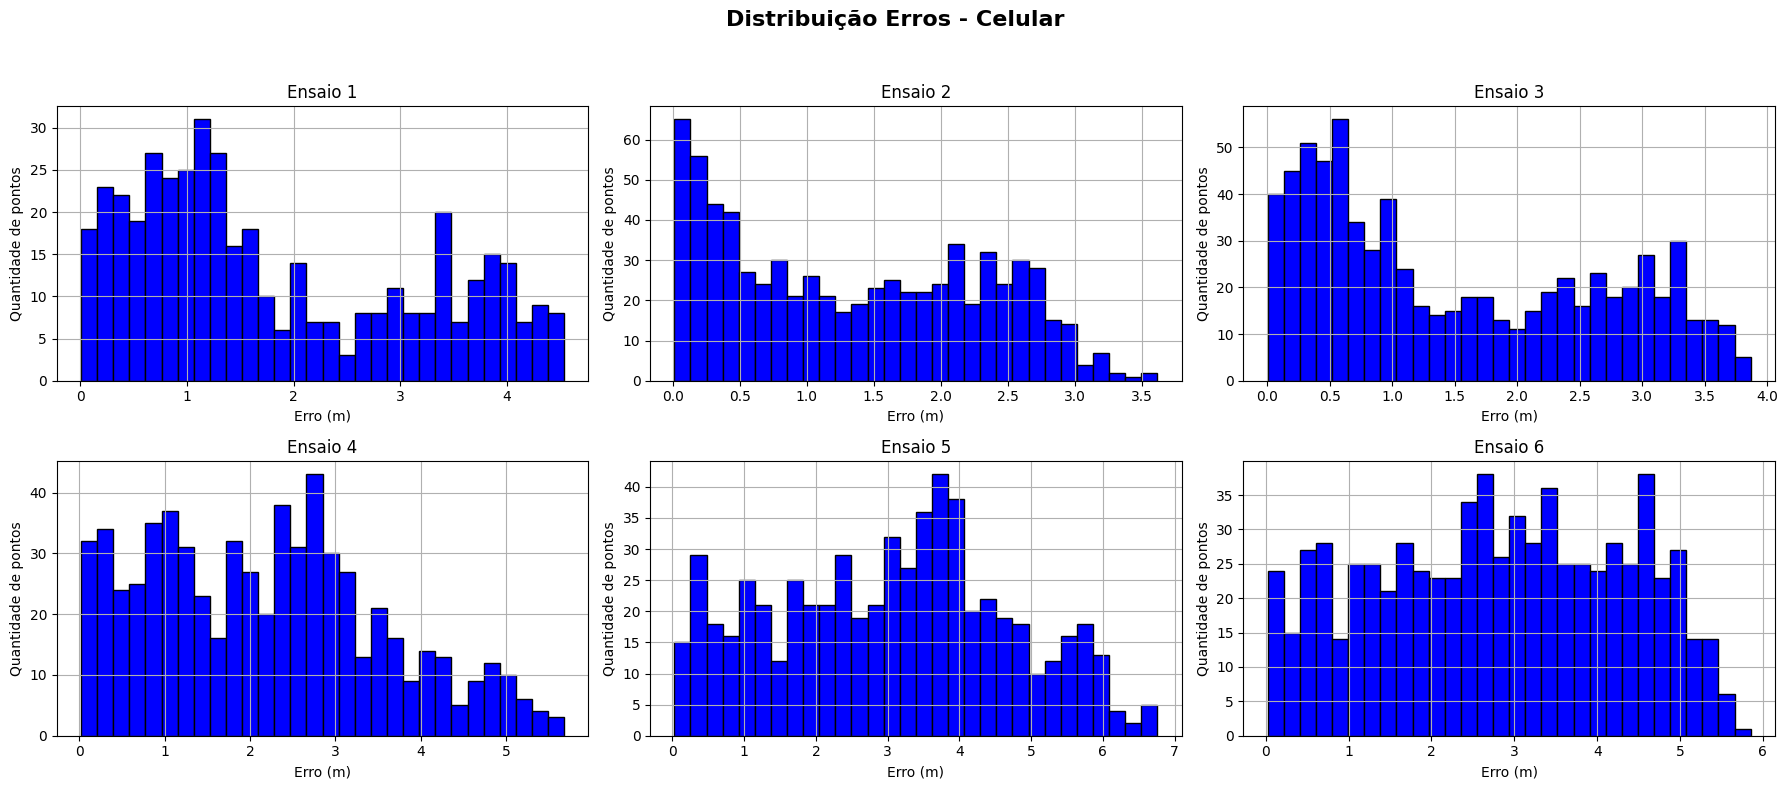

In [38]:
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Adiciona título geral antes dos subplots
fig.suptitle('Distribuição Erros - Celular', fontsize=16, fontweight='bold')

for i, lap_name in enumerate(laps.keys()):
    erros = laps[lap_name]['celular']['error_analysis']['euclidean_errors_m']
    
    axs[i].hist(erros, bins=30, color='blue', edgecolor='black')
    axs[i].set_title(f'{labels[i]}')
    axs[i].set_xlabel('Erro (m)')
    axs[i].set_ylabel('Quantidade de pontos')
    axs[i].grid(True)

# Oculta eixos extras se houver
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Ajusta o layout e reposiciona para não sobrepor o título
plt.tight_layout(rect=[0, 0, 1, 0.95])  # reserve espaço para o suptitle
plt.show()

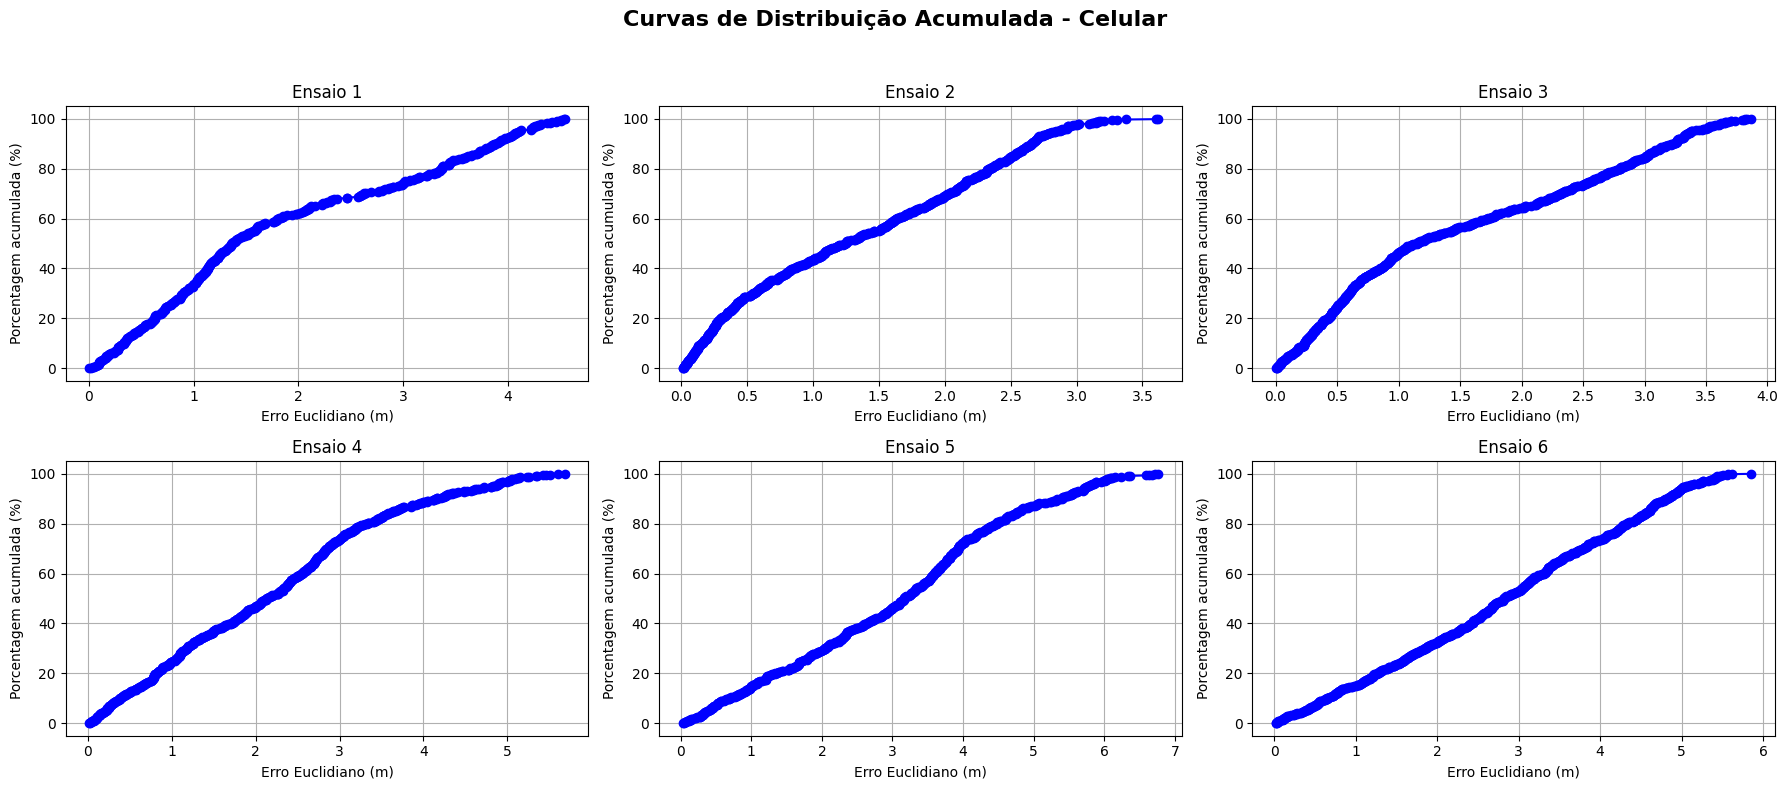

In [39]:
# Cria os subplots
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Título geral
fig.suptitle('Curvas de Distribuição Acumulada - Celular', fontsize=16, fontweight='bold')

for i, lap_name in enumerate(laps.keys()):
    # Erros euclidianos do ensaio atual
    errors = np.array(laps[lap_name]['celular']['error_analysis']['euclidean_errors_m'])

    # Ordena os erros
    sorted_errors = np.sort(errors)

    # Calcula as porcentagens acumuladas
    percentages = np.linspace(0, 100, len(sorted_errors))

    # Plota a curva de distribuição acumulada
    axs[i].plot(sorted_errors, percentages, marker='o', linestyle='-', color='blue')
    axs[i].set_title(f'{labels[i]}')
    axs[i].set_xlabel('Erro Euclidiano (m)')
    axs[i].set_ylabel('Porcentagem acumulada (%)')
    axs[i].grid(True)

# Desativa os eixos vazios (caso o número de subplots exceda o número de laps)
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Ajusta o layout para não sobrepor o título
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

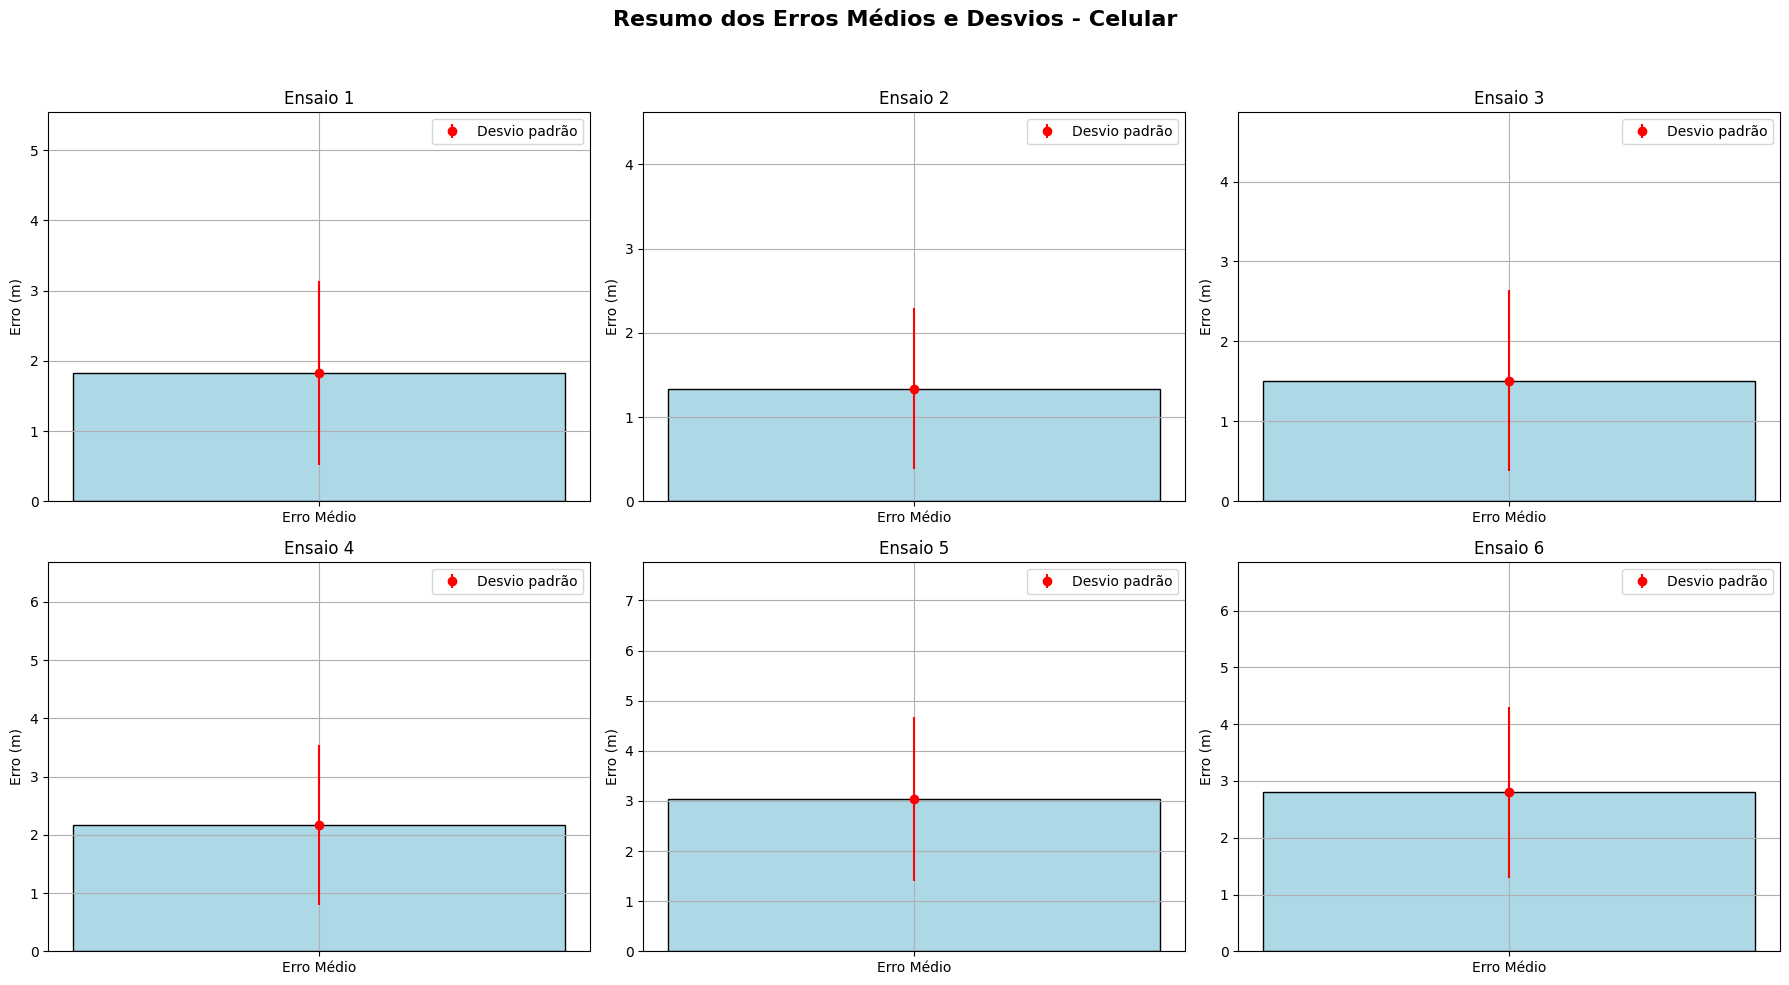

In [35]:
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axs = axs.flatten()

# Título geral
fig.suptitle('Resumo dos Erros Médios e Desvios - Celular', fontsize=16, fontweight='bold')

for i, lap_name in enumerate(lap_names):
    analysis = laps[lap_name]['celular']['error_analysis']
    mean_error = analysis['mean_euclidean_error_m']
    std_error = analysis['std_euclidean_error_m']
    max_error = analysis['max_euclidean_error_m']

    # Barra para erro médio
    axs[i].bar(['Erro Médio'], [mean_error], color='lightblue', edgecolor='black')

    # Linha de erro (desvio padrão)
    axs[i].errorbar('Erro Médio', mean_error, yerr=std_error, fmt='o', color='red', label='Desvio padrão')

    # Ajuste do eixo Y
    axs[i].set_ylim(0, max_error + 1)
    axs[i].set_title(f'{labels[i]}')
    axs[i].set_ylabel('Erro (m)')
    axs[i].legend()
    axs[i].grid(True)

# Oculta subplots não utilizados
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # reserva espaço para o título
plt.show()

### Erro Mínima Distância + Ângulo

Esse erro parece mais correto pois se eu tiver um deslocamento do meu circulo e ele fizer a intersecção na referência, a intersecção será o menor valor. O correto seria tentar pelo grau que aquele ponto se encontra baseado no seu ponto central que forma o circulo para os dados

In [40]:
def calcular_angulo(ponto, centro):
    delta_x = ponto[1] - centro[1]  # longitude
    delta_y = ponto[0] - centro[0]  # latitude
    angulo_rad = np.arctan2(delta_y, delta_x)
    angulo_deg = np.degrees(angulo_rad) % 360
    return angulo_deg

# Faz uma cópia da referência e calcula o ângulo dela uma única vez
ref = df_pivot.copy()
centro = (pivot_lat, pivot_long)  # Referência de latitude e longitude do centro
ref['angulo'] = ref.apply(
    lambda row: calcular_angulo((row['latitude'], row['longitude']), centro),
    axis=1
)

# Loop sobre cada volta
for lap_name in laps.keys():
    esp = laps[lap_name]["celular"].get("dataframe")
    if esp is None or esp.empty:
        continue

    erros_metros = []
    erros_ns = []
    erros_ew = []

    for _, ponto in esp.iterrows():
        ponto_ensaio = (ponto['latitude'], ponto['longitude'])
        angulo_ensaio = calcular_angulo(ponto_ensaio, centro)

        # Encontra o índice do ponto de referência com o ângulo mais próximo
        idx_ref = (ref['angulo'] - angulo_ensaio).abs().idxmin()
        ponto_ref = (ref.loc[idx_ref, 'latitude'], ref.loc[idx_ref, 'longitude'])

        # Calcula a distância geodésica
        erro_metro = geodesic(ponto_ensaio, ponto_ref).meters
        erros_metros.append(erro_metro)

        # Calcula as diferenças de latitude e longitude para N-S e E-W
        delta_lat = ponto_ensaio[0] - ponto_ref[0]
        delta_lon = ponto_ensaio[1] - ponto_ref[1]

        # Conversão para metros
        delta_ns = delta_lat * 111320  # Aproximadamente metros por grau de latitude
        lat_media = (ponto_ensaio[0] + ponto_ref[0]) / 2
        delta_ew = delta_lon * 111320 * np.cos(np.radians(lat_media))  # Aproximadamente metros por grau de longitude

        # Armazena os erros N-S e E-W
        erros_ns.append(delta_ns)
        erros_ew.append(delta_ew)

    # Calcula as estatísticas de erro
    media_erro = np.mean(erros_metros)
    desvio_erro = np.std(erros_metros)
    max_erro = np.max(erros_metros)
    min_erro = np.min(erros_metros)
    dois_sigma = 2 * desvio_erro

    # Calcula estatísticas para N-S e E-W
    media_ns_erro = np.mean(erros_ns)
    desvio_ns_erro = np.std(erros_ns)
    max_ns_erro = np.max(erros_ns)
    min_ns_erro = np.min(erros_ns)

    media_ew_erro = np.mean(erros_ew)
    desvio_ew_erro = np.std(erros_ew)
    max_ew_erro = np.max(erros_ew)
    min_ew_erro = np.min(erros_ew)

    # Armazenamento dos resultados na estrutura de dados
    laps[lap_name]["celular"]["erro_analysis_angle"] = {
        'media_erro_m': media_erro,
        'desvio_erro_m': desvio_erro,
        '2sigma_m': dois_sigma,
        'max_erro_m': max_erro,
        'min_erro_m': min_erro,
        'qtd_pontos': len(erros_metros),
        'erros_metros': erros_metros,
        'media_ns_erro_m': media_ns_erro,
        'desvio_ns_erro_m': desvio_ns_erro,
        'max_ns_erro_m': max_ns_erro,
        'min_ns_erro_m': min_ns_erro,
        'erros_ns_m': erros_ns,
        'media_ew_erro_m': media_ew_erro,
        'desvio_ew_erro_m': desvio_ew_erro,
        'max_ew_erro_m': max_ew_erro,
        'min_ew_erro_m': min_ew_erro,
        'erros_ew_m': erros_ew
    }

# Exibe o resumo dos resultados
for lap_name in laps.keys():
    ana = laps[lap_name]["celular"].get("erro_analysis_angle")
    if not ana:
        continue
    print(f"\n{lap_name} (celular, erro por ângulo):")
    print(f"  ➔ Erro médio (m): {ana['media_erro_m']:.2f}")
    print(f"  ➔ Desvio padrão (m): {ana['desvio_erro_m']:.2f}")
    print(f"  ➔ 2σ (m): {ana['2sigma_m']:.2f}")
    print(f"  ➔ Erro máximo (m): {ana['max_erro_m']:.2f}")
    print(f"  ➔ Erro mínimo (m): {ana['min_erro_m']:.2f}")
    print(f"  ➔ Pontos avaliados: {ana['qtd_pontos']}")
    print(f"  ➔ Média do erro N-S (m): {ana['media_ns_erro_m']:.2f}")
    print(f"  ➔ Desvio padrão N-S (m): {ana['desvio_ns_erro_m']:.2f}")
    print(f"  ➔ Máximo N-S (m): {ana['max_ns_erro_m']:.2f}")
    print(f"  ➔ Mínimo N-S (m): {ana['min_ns_erro_m']:.2f}")
    print(f"  ➔ Média do erro E-W (m): {ana['media_ew_erro_m']:.2f}")
    print(f"  ➔ Desvio padrão E-W (m): {ana['desvio_ew_erro_m']:.2f}")
    print(f"  ➔ Máximo E-W (m): {ana['max_ew_erro_m']:.2f}")
    print(f"  ➔ Mínimo E-W (m): {ana['min_ew_erro_m']:.2f}")



lap_1 (celular, erro por ângulo):
  ➔ Erro médio (m): 1.83
  ➔ Desvio padrão (m): 1.31
  ➔ 2σ (m): 2.63
  ➔ Erro máximo (m): 4.54
  ➔ Erro mínimo (m): 0.01
  ➔ Pontos avaliados: 432
  ➔ Média do erro N-S (m): -0.39
  ➔ Desvio padrão N-S (m): 1.43
  ➔ Máximo N-S (m): 2.34
  ➔ Mínimo N-S (m): -3.73
  ➔ Média do erro E-W (m): -1.06
  ➔ Desvio padrão E-W (m): 1.33
  ➔ Máximo E-W (m): 0.79
  ➔ Mínimo E-W (m): -4.46

lap_2 (celular, erro por ângulo):
  ➔ Erro médio (m): 1.34
  ➔ Desvio padrão (m): 0.95
  ➔ 2σ (m): 1.90
  ➔ Erro máximo (m): 3.62
  ➔ Erro mínimo (m): 0.01
  ➔ Pontos avaliados: 720
  ➔ Média do erro N-S (m): -0.56
  ➔ Desvio padrão N-S (m): 1.06
  ➔ Máximo N-S (m): 1.55
  ➔ Mínimo N-S (m): -3.23
  ➔ Média do erro E-W (m): -0.18
  ➔ Desvio padrão E-W (m): 1.12
  ➔ Máximo E-W (m): 2.18
  ➔ Mínimo E-W (m): -3.06

lap_3 (celular, erro por ângulo):
  ➔ Erro médio (m): 1.51
  ➔ Desvio padrão (m): 1.13
  ➔ 2σ (m): 2.27
  ➔ Erro máximo (m): 3.87
  ➔ Erro mínimo (m): 0.00
  ➔ Pontos av

## Garmin

In [41]:
'''
    Para carregar os dados do garmin, foi necessário utilizar uma outra abordagem, tendo em vista que sua saída é em csv, mas a estrutura
    do arquivo está toda bagunçada, sendo necessário remover alguns conteúdos na mão e posteriormente carregar o arquivo pensando em uma divisão
    por tabulação.

    CORREÇÂO: alguns arquivos estavam separados por vírgula, não sei o que aconteceu na hora da exportação dos dados
'''

with open("Dados/garmin_volta_4.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_250_1 = pd.read_csv(io.StringIO(texto), sep="\t", engine="python")

with open("Dados/garmin_volta_5.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_250_2 = pd.read_csv(io.StringIO(texto), sep="\t", engine="python")

with open("Dados/garmin_volta_6.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_250_3 = pd.read_csv(io.StringIO(texto), sep=",", engine="python")

with open("Dados/garmin_volta_7.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_125_1 = pd.read_csv(io.StringIO(texto), sep=",", engine="python")

with open("Dados/garmin_volta_8.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_125_2 = pd.read_csv(io.StringIO(texto), sep="\t", engine="python")


with open("Dados/garmin_volta_2.csv", "r", encoding="utf-8") as f:
    texto = f.read().replace('"', '')
df_garmin_125_3 = pd.read_csv(io.StringIO(texto), sep="\t", engine="python")



laps["lap_1"]["garmin"]["dataframe"] = df_garmin_250_1
laps["lap_2"]["garmin"]["dataframe"] = df_garmin_250_2
laps["lap_3"]["garmin"]["dataframe"] = df_garmin_250_3
laps["lap_4"]["garmin"]["dataframe"] = df_garmin_125_1
laps["lap_5"]["garmin"]["dataframe"] = df_garmin_125_2
laps["lap_6"]["garmin"]["dataframe"] = df_garmin_125_3

print(laps["lap_1"]["garmin"]["dataframe"].shape)
print(laps["lap_2"]["garmin"]["dataframe"].shape)
print(laps["lap_3"]["garmin"]["dataframe"].shape)
print(laps["lap_4"]["garmin"]["dataframe"].shape)
print(laps["lap_5"]["garmin"]["dataframe"].shape)
print(laps["lap_6"]["garmin"]["dataframe"].shape)


(1094, 30)
(1007, 30)
(1083, 27)
(1126, 27)
(860, 26)
(1396, 30)


In [42]:
laps["lap_6"]["garmin"]["dataframe"]

,ID,trksegID,lat,lon,ele,time,magvar,geoidheight,name,cmt,...,dgpsid,Temperature,Depth,wtemp,hr,cad,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,1,1.0,-22.713.475.339.114.600,-47.628.267.528.489.200,627.397.705.078.125,2025-04-23T18:09:54Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.0,-22.713.442.984.968.400,-47.628.420.330.584.000,58.702.197.265.625,2025-04-23T18:09:59Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.0,-22.713.390.681.892.600,-47.628.602.385.520.900,555.779.296.875,2025-04-23T18:10:04Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.0,-22.713.394.621.387.100,-47.628.595.931.455.400,55.481.787.109.375,2025-04-23T18:10:09Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.0,-22.713.398.141.786.400,-47.628.578.580.915.900,556.260.009.765.625,2025-04-23T18:10:14Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,1392,1.0,-227.133.958.786.726,-47.628.631.554.543.900,54.424.365.234.375,2025-04-23T20:05:50Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1392,1393,1.0,-22.713.396.046.310.600,-47.628.631.722.182.000,54.424.365.234.375,2025-04-23T20:05:55Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1393,1394,1.0,-22.713.396.046.310.600,-47.628.631.973.639.100,54.424.365.234.375,2025-04-23T20:06:00Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1394,1395,1.0,-22.713.396.046.310.600,-47.628.632.057.458.100,54.424.365.234.375,2025-04-23T20:06:03Z,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Função para limpar e formatar as coordenadas, pois o garmin fornece a string meio estranha, como: -22485693359 ao invés de -22.485693359
# também vou ajustar a hora da minha coluna, pois está 3 horas adiantada
def clean_coord(val):
    try:
        if pd.isna(val):
            return None
        s = str(val).replace('.', '')
        if len(s) < 3:
            return None
        # Ajusta para ter 2 dígitos antes do ponto
        return float(s[:3] + '.' + s[3:])
    except Exception:
        return None

for lap_name, lap_data in laps.items():
    df_gar = lap_data.get("garmin", {}).get("dataframe")
    if df_gar is None or df_gar.empty:
        continue

    # print(df_gar["time"])

    df_gar['time'] = (
        pd.to_datetime(df_gar['time'])
          .dt.tz_convert(None)            # remove timezone se já tiver
          - pd.Timedelta(hours=3)         # Garmin grava +3h
    ).dt.tz_localize("America/Sao_Paulo")  # aplica fuso SP


    start = pd.Timestamp(lap_data['lap_start']).tz_localize("America/Sao_Paulo") + pd.Timedelta(minutes=5)
    end   = pd.Timestamp(lap_data['lap_end'  ]).tz_localize("America/Sao_Paulo") - pd.Timedelta(minutes=5)
    df_gar = df_gar[(df_gar['time'] >= start) & (df_gar['time'] <= end)]

    df_gar = df_gar.sort_values('time').reset_index(drop=True)


    df_gar['lat'] = df_gar['lat'].apply(clean_coord)
    df_gar['lon'] = df_gar['lon'].apply(clean_coord)

    drop_cols = [c for c in df_gar.columns if c.startswith("Unnamed:")]
    df_gar = df_gar.drop(columns=drop_cols)

    df_gar.rename(columns={'lat': 'latitude', 'lon': 'longitude'}, inplace=True)


    laps[lap_name]["garmin"]["dataframe"] = df_gar

In [44]:
laps["lap_6"]["garmin"]["dataframe"]

,ID,trksegID,latitude,longitude,ele,time,magvar,geoidheight,name,cmt,...,hdop,vdop,pdop,ageofdgpsdata,dgpsid,Temperature,Depth,wtemp,hr,cad
0,554,1.0,-22.713454,-47.628448,5.384.757.080.078.120,2025-04-23 15:56:00-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,555,1.0,-22.713507,-47.628517,5.384.757.080.078.120,2025-04-23 15:56:05-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,556,1.0,-22.713485,-47.628602,538.956.298.828.125,2025-04-23 15:56:10-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,557,1.0,-22.713406,-47.628645,5.384.757.080.078.120,2025-04-23 15:56:15-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,558,1.0,-22.713340,-47.628601,538.956.298.828.125,2025-04-23 15:56:20-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,1270,1.0,-22.713531,-47.628526,5.432.821.044.921.870,2025-04-23 16:55:40-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717,1271,1.0,-22.713505,-47.628611,5.432.821.044.921.870,2025-04-23 16:55:45-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
718,1272,1.0,-22.713422,-47.628646,5.432.821.044.921.870,2025-04-23 16:55:50-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
719,1273,1.0,-22.713347,-47.628605,542.801.513.671.875,2025-04-23 16:55:55-03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


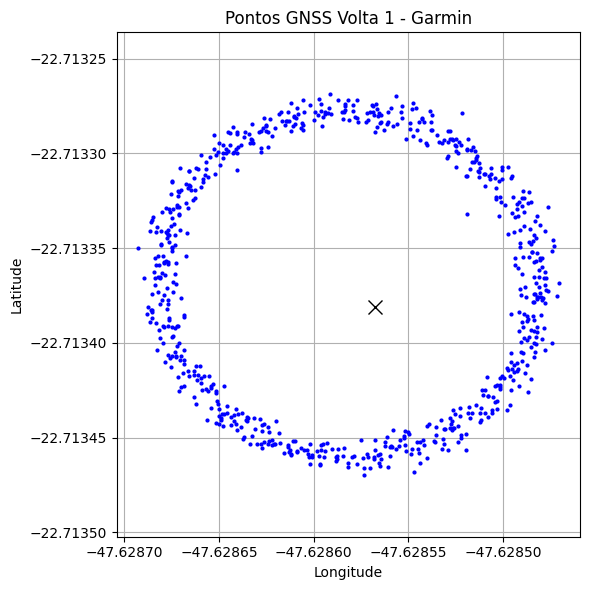

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(laps['lap_1']["garmin"]["dataframe"]["longitude"], laps['lap_1']["garmin"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue')
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=10, label='Ponto de Pivô')
ax.set_title("Pontos GNSS Volta 1 - Garmin")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()

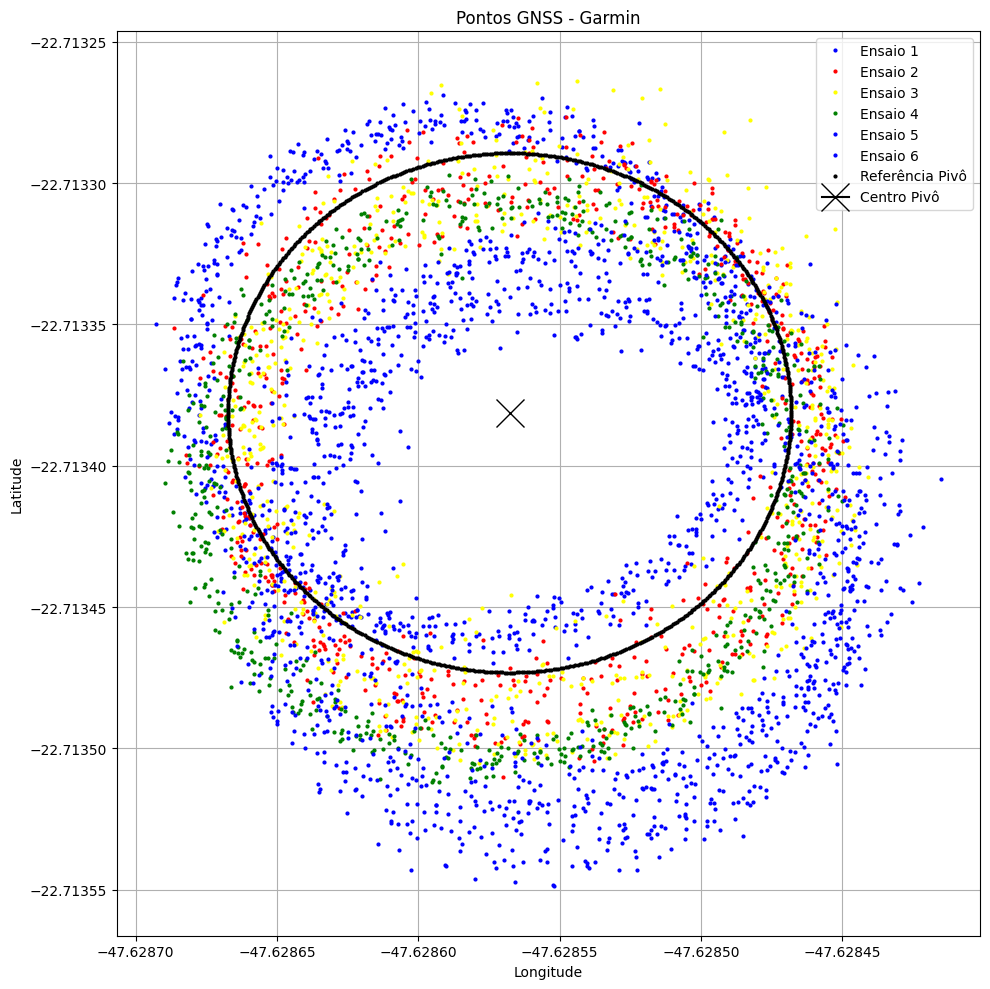

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot( laps['lap_1']["garmin"]["dataframe"]["longitude"], laps['lap_1']["garmin"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 1")
ax.plot( laps['lap_2']["garmin"]["dataframe"]["longitude"], laps['lap_2']["garmin"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='red', label="Ensaio 2")
ax.plot( laps['lap_3']["garmin"]["dataframe"]["longitude"], laps['lap_3']["garmin"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='yellow', label="Ensaio 3")
ax.plot( laps['lap_4']["garmin"]["dataframe"]["longitude"], laps['lap_4']["garmin"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='green', label="Ensaio 4")
ax.plot( laps['lap_5']["garmin"]["dataframe"]["longitude"], laps['lap_5']["garmin"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 5")
ax.plot( laps['lap_6']["garmin"]["dataframe"]["longitude"], laps['lap_6']["garmin"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 6")
ax.plot(df_pivot["longitude"], df_pivot["latitude"], marker='o', linestyle="", markersize=2, color='black', label="Referência Pivô")
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=20, label="Centro Pivô")

ax.legend()

ax.set_title("Pontos GNSS - Garmin")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()

In [47]:
# Cria o mapa centralizado no pivô
map_garmin = folium.Map(location=[pivot_lat, pivot_long], zoom_start=17, tiles="OpenStreetMap")

# Define as voltas, cores e rótulos
laps_to_plot = ['lap_1', 'lap_2', 'lap_3', 'lap_4', 'lap_5', 'lap_6']
colors = ['blue', 'red', 'yellow', 'green', 'purple', 'orange']
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

# Adiciona os pontos de cada volta Garmin
for lap_name, color, label in zip(laps_to_plot, colors, labels):
    df = laps.get(lap_name, {}).get("garmin", {}).get("dataframe")
    if df is None or df.empty:
        continue

    for _, row in df.iterrows():
        if pd.notna(row['latitude']) and pd.notna(row['longitude']):
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=2,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=f"{label}"
            ).add_to(map_garmin)

# Adiciona os pontos de referência do pivô
for _, row in df_pivot.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        popup="Referência Pivô"
    ).add_to(map_garmin)

# Marca o centro do pivô
folium.Marker(
    location=[pivot_lat, pivot_long],
    icon=folium.Icon(color='black', icon='star'),
    popup="Centro Pivô"
).add_to(map_garmin)

# Salva o mapa
map_garmin.save("mapa_garmin.html")


### Erro Mínima Distância Geodésica

Esse método de cálculo de erro analisa a menor distância geodésica de cada ponto para o ponto mais próximo da referência do pivô

In [48]:
for lap_name in laps.keys():
    lap_df = laps[lap_name]["garmin"].get("dataframe")
    if lap_df is None or lap_df.empty:
        continue

    euclidean_errors = []
    north_south_errors = []
    east_west_errors = []

    for _, lap_point in lap_df.iterrows():
        test_point = (lap_point['latitude'], lap_point['longitude'])

        # Calcula a distância geodésica para todos os pontos de referência
        distances = [
            geodesic(test_point, (row['latitude'], row['longitude'])).meters
            for _, row in df_pivot.iterrows()
        ]

        # Identifica o ponto de referência mais próximo
        idx_min = np.argmin(distances)
        ref_point = df_pivot.iloc[idx_min]

        # Diferença de coordenadas
        delta_lat = lap_point['latitude'] - ref_point['latitude']
        delta_lon = lap_point['longitude'] - ref_point['longitude']

        # Converte diferença em metros
        delta_ns = delta_lat * 111320  # metros por grau de Lat
        avg_lat = (lap_point['latitude'] + ref_point['latitude']) / 2
        delta_ew = delta_lon * 111320 * np.cos(np.radians(avg_lat))  # metros por grau de Lon

        # Armazena erros
        euclidean_errors.append(distances[idx_min])
        north_south_errors.append(delta_ns)
        east_west_errors.append(delta_ew)

    # Calcula estatísticas
    mean_euclidean_error = np.mean(euclidean_errors)
    mean_ns_error = np.mean(north_south_errors)
    mean_ew_error = np.mean(east_west_errors)

    std_euclidean_error = np.std(euclidean_errors)
    std_ns_error = np.std(north_south_errors)
    std_ew_error = np.std(east_west_errors)

    max_euclidean_error = np.max(euclidean_errors)
    max_ns_error = np.max(north_south_errors)
    max_ew_error = np.max(east_west_errors)

    min_euclidean_error = np.min(euclidean_errors)
    min_ns_error = np.min(north_south_errors)
    min_ew_error = np.min(east_west_errors)

    two_sigma = 2 * std_euclidean_error

    # Calcula o erro circular provável (CEP)
    cep = 1.18 * math.sqrt(std_ns_error**2 + std_ew_error**2)

    # Armazena no dicionário laps
    laps[lap_name]["garmin"]["error_analysis"] = {
        'mean_euclidean_error_m': mean_euclidean_error,
        'mean_ns_error_m': mean_ns_error,
        'mean_ew_error_m': mean_ew_error,
        'std_euclidean_error_m': std_euclidean_error,
        'std_ns_error_m': std_ns_error,
        'std_ew_error_m': std_ew_error,
        '2sigma_m': two_sigma,
        'cep_m': cep,
        'max_euclidean_error_m': max_euclidean_error,
        'max_ns_error_m': max_ns_error,
        'max_ew_error_m': max_ew_error,
        'min_euclidean_error_m': min_euclidean_error,
        'min_ns_error_m': min_ns_error,
        'min_ew_error_m': min_ew_error,
        'num_points': len(euclidean_errors),
        'euclidean_errors_m': euclidean_errors,
        'north_south_errors_m': north_south_errors,
        'east_west_errors_m': east_west_errors
    }

# Exibe os resultados
for lap_name in laps.keys():
    if "garmin" in laps[lap_name] and "error_analysis" in laps[lap_name]["garmin"]:
        res = laps[lap_name]["garmin"]["error_analysis"]
        print(f"\n{lap_name}:")
        print(f"  ➔ Erro médio (m): {res['mean_euclidean_error_m']:.2f}")
        print(f"  ➔ Desvio padrão (m): {res['std_euclidean_error_m']:.2f}")
        print(f"  ➔ 2σ (m): {res['2sigma_m']:.2f}")
        print(f"  ➔ Erro máximo (m): {res['max_euclidean_error_m']:.2f}")
        print(f"  ➔ Erro mínimo (m): {res['min_euclidean_error_m']:.2f}")
        print(f"  ➔ Quantidade de pontos: {res['num_points']}")
        print(f"  ➔ Média do erro N-S (m): {res['mean_ns_error_m']:.2f}")
        print(f"  ➔ Desvio padrão N-S (m): {res['std_ns_error_m']:.2f}")
        print(f"  ➔ Máximo N-S (m): {res['max_ns_error_m']:.2f}")
        print(f"  ➔ Mínimo N-S (m): {res['min_ns_error_m']:.2f}")
        print(f"  ➔ Média do erro E-W (m): {res['mean_ew_error_m']:.2f}")
        print(f"  ➔ Desvio padrão E-W (m): {res['std_ew_error_m']:.2f}")
        print(f"  ➔ Máximo E-W (m): {res['max_ew_error_m']:.2f}")
        print(f"  ➔ Mínimo E-W (m): {res['min_ew_error_m']:.2f}")
        print(f"  ➔ CEP (m): {res['cep_m']:.2f}")


lap_1:
  ➔ Erro médio (m): 1.31
  ➔ Desvio padrão (m): 0.74
  ➔ 2σ (m): 1.48
  ➔ Erro máximo (m): 3.12
  ➔ Erro mínimo (m): 0.02
  ➔ Quantidade de pontos: 720
  ➔ Média do erro N-S (m): 0.69
  ➔ Desvio padrão N-S (m): 0.81
  ➔ Máximo N-S (m): 2.92
  ➔ Mínimo N-S (m): -2.12
  ➔ Média do erro E-W (m): -0.71
  ➔ Desvio padrão E-W (m): 0.80
  ➔ Máximo E-W (m): 1.07
  ➔ Mínimo E-W (m): -2.97
  ➔ CEP (m): 1.34

lap_2:
  ➔ Erro médio (m): 1.10
  ➔ Desvio padrão (m): 0.84
  ➔ 2σ (m): 1.68
  ➔ Erro máximo (m): 4.09
  ➔ Erro mínimo (m): 0.01
  ➔ Quantidade de pontos: 721
  ➔ Média do erro N-S (m): -0.57
  ➔ Desvio padrão N-S (m): 0.95
  ➔ Máximo N-S (m): 1.89
  ➔ Mínimo N-S (m): -4.11
  ➔ Média do erro E-W (m): 0.27
  ➔ Desvio padrão E-W (m): 0.80
  ➔ Máximo E-W (m): 2.67
  ➔ Mínimo E-W (m): -2.30
  ➔ CEP (m): 1.46

lap_3:
  ➔ Erro médio (m): 1.46
  ➔ Desvio padrão (m): 0.98
  ➔ 2σ (m): 1.96
  ➔ Erro máximo (m): 4.47
  ➔ Erro mínimo (m): 0.02
  ➔ Quantidade de pontos: 721
  ➔ Média do erro N-S 

In [49]:
# Estrutura organizada dos erros do garmin
error_data_garmin = []

# Define os rótulos das voltas
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']

for i, lap_name in enumerate(laps.keys()):
    error_analysis = laps[lap_name]['garmin']['error_analysis']
    
    error_data_garmin.append({
        'Ensaio': labels[i],

        'EMP': error_analysis['mean_euclidean_error_m'],
        'EM/L-O': error_analysis['mean_ew_error_m'],
        'EM/N-S': error_analysis['mean_ns_error_m'],

        'DP': error_analysis['std_euclidean_error_m'],
        'DP/L-O': error_analysis['std_ew_error_m'],
        'DP/N-S': error_analysis['std_ns_error_m'],

        '2σ': error_analysis['2sigma_m'],
        'CEP': error_analysis['cep_m'],

        'Max Error': error_analysis['max_euclidean_error_m'],
        'Min Error': error_analysis['min_euclidean_error_m'],

        'Num Points': error_analysis['num_points']
    })

# Cria o DataFrame
df_error_garmin = pd.DataFrame(error_data_garmin)

df_error_garmin

,Ensaio,EMP,EM/L-O,EM/N-S,DP,DP/L-O,DP/N-S,2σ,CEP,Max Error,Min Error,Num Points
0,Ensaio 1,1.308099,-0.711364,0.688901,0.742111,0.798722,0.808621,1.484221,1.341170,3.123461,0.018193,720
1,Ensaio 2,1.103522,0.270336,-0.573981,0.838731,0.795975,0.947189,1.677462,1.459934,4.091413,0.009389,721
2,Ensaio 3,1.463962,0.482272,-0.661768,0.978151,0.973134,1.225333,1.956301,1.846400,4.466572,0.018688,721
3,Ensaio 4,1.897444,-0.185853,-1.427369,1.092793,1.165855,1.182231,2.185586,1.959258,4.923542,0.017290,720
4,Ensaio 5,3.795589,0.692796,-2.830315,2.028105,2.139772,2.363628,4.056210,3.762213,8.427841,0.023113,720
5,Ensaio 6,3.646326,1.477549,-2.261454,1.925707,2.174548,2.253248,3.851414,3.695075,8.441520,0.009948,721


In [50]:
# Parâmetros para Criação dos Gráficos
num_laps = len(laps)
cols = 3
rows = int(np.ceil(num_laps / cols))

lap_names = list(laps.keys())
labels = ['Ensaio 1', 'Ensaio 2', 'Ensaio 3', 'Ensaio 4', 'Ensaio 5', 'Ensaio 6']  # ajuste conforme necessário

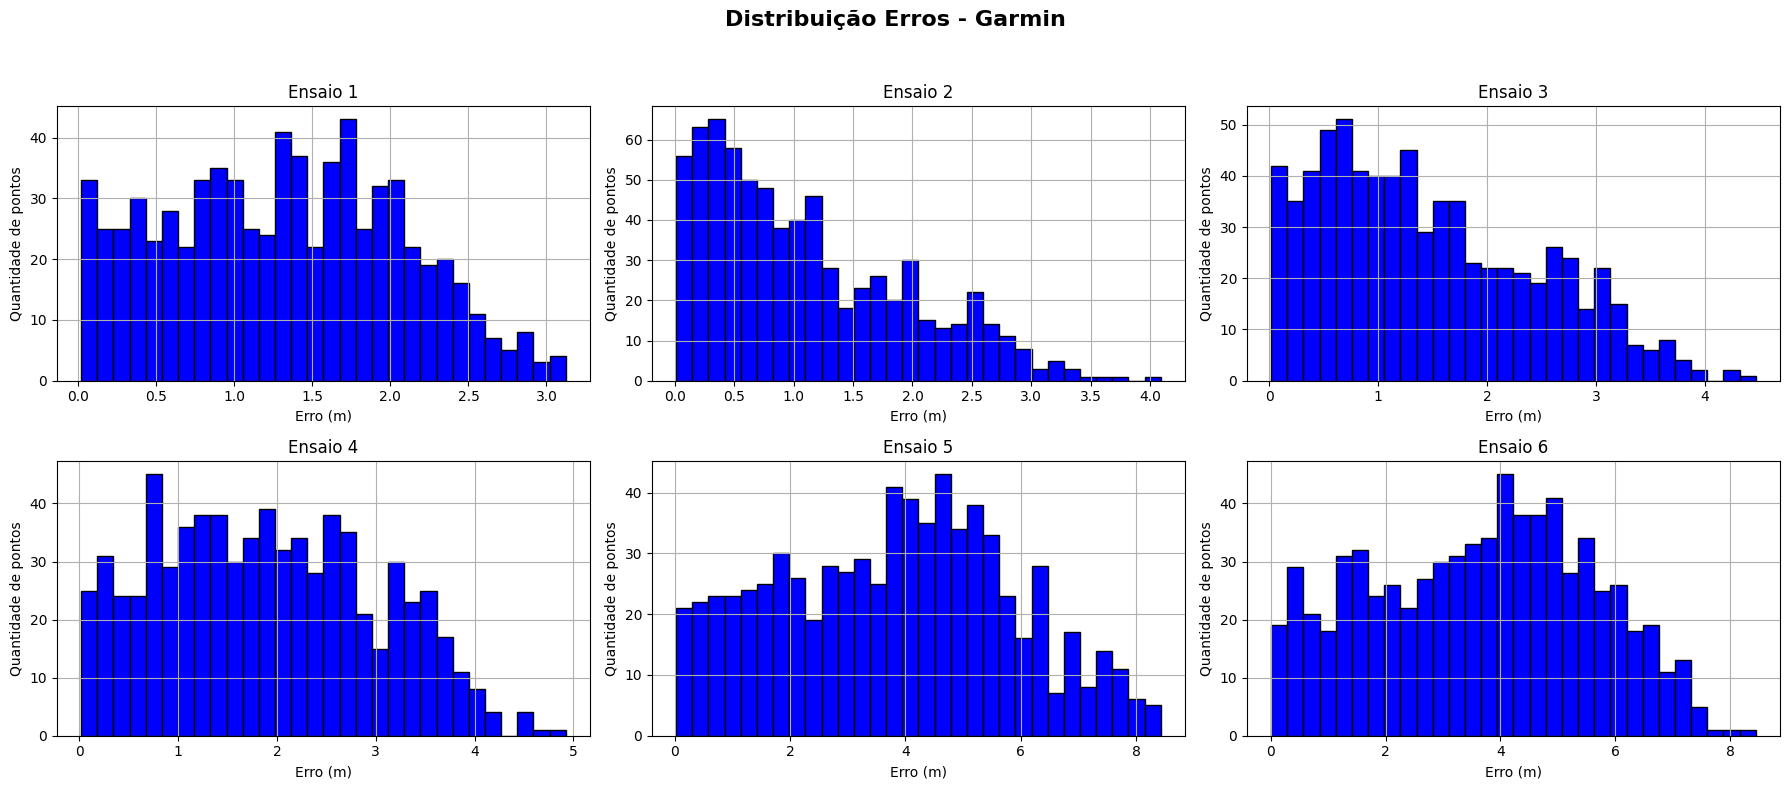

In [51]:
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Adiciona título geral antes dos subplots
fig.suptitle('Distribuição Erros - Garmin', fontsize=16, fontweight='bold')

for i, lap_name in enumerate(laps.keys()):
    erros = laps[lap_name]['garmin']['error_analysis']['euclidean_errors_m']
    
    axs[i].hist(erros, bins=30, color='blue', edgecolor='black')
    axs[i].set_title(f'{labels[i]}')
    axs[i].set_xlabel('Erro (m)')
    axs[i].set_ylabel('Quantidade de pontos')
    axs[i].grid(True)

# Oculta eixos extras se houver
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Ajusta o layout e reposiciona para não sobrepor o título
plt.tight_layout(rect=[0, 0, 1, 0.95])  # reserve espaço para o suptitle
plt.show()

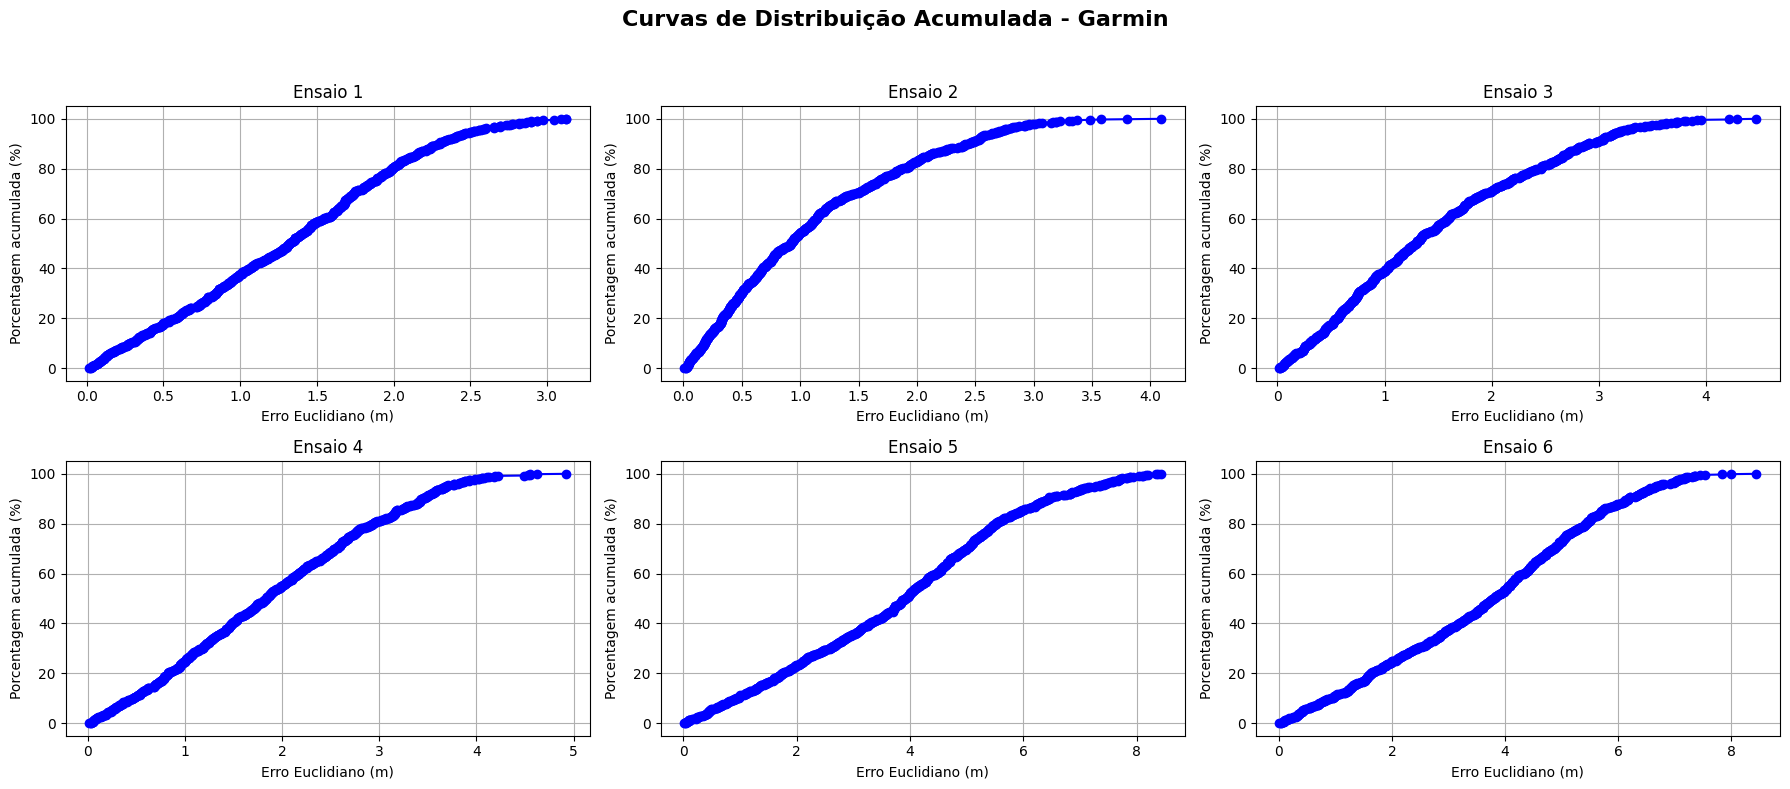

In [54]:
# Cria os subplots
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axs = axs.flatten()

# Título geral
fig.suptitle('Curvas de Distribuição Acumulada - Garmin', fontsize=16, fontweight='bold')

for i, lap_name in enumerate(laps.keys()):
    # Erros euclidianos do ensaio atual
    errors = np.array(laps[lap_name]['garmin']['error_analysis']['euclidean_errors_m'])

    # Ordena os erros
    sorted_errors = np.sort(errors)

    # Calcula as porcentagens acumuladas
    percentages = np.linspace(0, 100, len(sorted_errors))

    # Plota a curva de distribuição acumulada
    axs[i].plot(sorted_errors, percentages, marker='o', linestyle='-', color='blue')
    axs[i].set_title(f'{labels[i]}')
    axs[i].set_xlabel('Erro Euclidiano (m)')
    axs[i].set_ylabel('Porcentagem acumulada (%)')
    axs[i].grid(True)

# Desativa os eixos vazios (caso o número de subplots exceda o número de laps)
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Ajusta o layout para não sobrepor o título
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

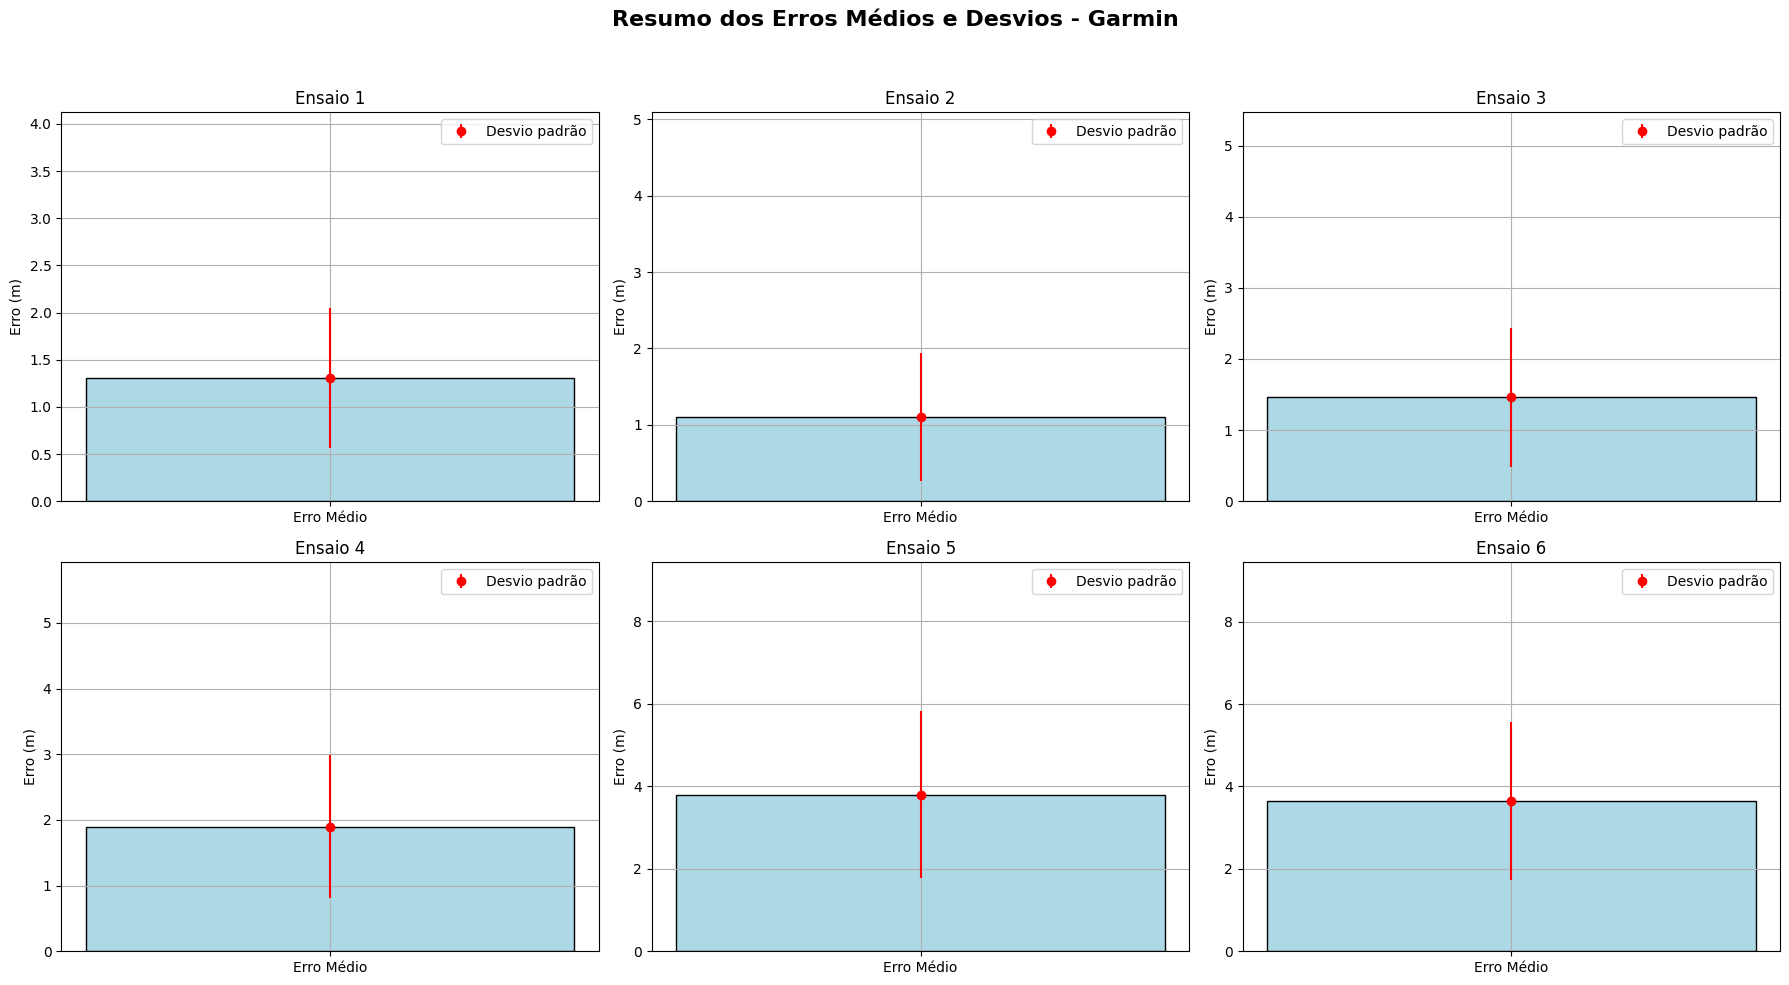

In [55]:
fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axs = axs.flatten()

# Título geral
fig.suptitle('Resumo dos Erros Médios e Desvios - Garmin', fontsize=16, fontweight='bold')

for i, lap_name in enumerate(lap_names):
    analysis = laps[lap_name]['garmin']['error_analysis']
    mean_error = analysis['mean_euclidean_error_m']
    std_error = analysis['std_euclidean_error_m']
    max_error = analysis['max_euclidean_error_m']

    # Barra para erro médio
    axs[i].bar(['Erro Médio'], [mean_error], color='lightblue', edgecolor='black')

    # Linha de erro (desvio padrão)
    axs[i].errorbar('Erro Médio', mean_error, yerr=std_error, fmt='o', color='red', label='Desvio padrão')

    # Ajuste do eixo Y
    axs[i].set_ylim(0, max_error + 1)
    axs[i].set_title(f'{labels[i]}')
    axs[i].set_ylabel('Erro (m)')
    axs[i].legend()
    axs[i].grid(True)

# Oculta subplots não utilizados
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # reserva espaço para o título
plt.show()

### Erro Mínima Distância + Ângulo

Esse erro parece mais correto pois se eu tiver um deslocamento do meu circulo e ele fizer a intersecção na referência, a intersecção será o menor valor. O correto seria tentar pelo grau que aquele ponto se encontra baseado no seu ponto central que forma o circulo para os dados

In [56]:
def calcular_angulo(ponto, centro):
    delta_x = ponto[1] - centro[1]  # longitude
    delta_y = ponto[0] - centro[0]  # latitude
    angulo_rad = np.arctan2(delta_y, delta_x)
    angulo_deg = np.degrees(angulo_rad) % 360
    return angulo_deg

# Faz uma cópia da referência e calcula o ângulo dela uma única vez
ref = df_pivot.copy()
centro = (pivot_lat, pivot_long)  # Referência de latitude e longitude do centro
ref['angulo'] = ref.apply(
    lambda row: calcular_angulo((row['latitude'], row['longitude']), centro),
    axis=1
)

# Loop sobre cada volta
for lap_name in laps.keys():
    esp = laps[lap_name]["garmin"].get("dataframe")
    if esp is None or esp.empty:
        continue

    erros_metros = []
    erros_ns = []
    erros_ew = []

    for _, ponto in esp.iterrows():
        ponto_ensaio = (ponto['latitude'], ponto['longitude'])
        angulo_ensaio = calcular_angulo(ponto_ensaio, centro)

        # Encontra o índice do ponto de referência com o ângulo mais próximo
        idx_ref = (ref['angulo'] - angulo_ensaio).abs().idxmin()
        ponto_ref = (ref.loc[idx_ref, 'latitude'], ref.loc[idx_ref, 'longitude'])

        # Calcula a distância geodésica
        erro_metro = geodesic(ponto_ensaio, ponto_ref).meters
        erros_metros.append(erro_metro)

        # Calcula as diferenças de latitude e longitude para N-S e E-W
        delta_lat = ponto_ensaio[0] - ponto_ref[0]
        delta_lon = ponto_ensaio[1] - ponto_ref[1]

        # Conversão para metros
        delta_ns = delta_lat * 111320  # Aproximadamente metros por grau de latitude
        lat_media = (ponto_ensaio[0] + ponto_ref[0]) / 2
        delta_ew = delta_lon * 111320 * np.cos(np.radians(lat_media))  # Aproximadamente metros por grau de longitude

        # Armazena os erros N-S e E-W
        erros_ns.append(delta_ns)
        erros_ew.append(delta_ew)

    # Calcula as estatísticas de erro
    media_erro = np.mean(erros_metros)
    desvio_erro = np.std(erros_metros)
    max_erro = np.max(erros_metros)
    min_erro = np.min(erros_metros)
    dois_sigma = 2 * desvio_erro

    # Calcula estatísticas para N-S e E-W
    media_ns_erro = np.mean(erros_ns)
    desvio_ns_erro = np.std(erros_ns)
    max_ns_erro = np.max(erros_ns)
    min_ns_erro = np.min(erros_ns)

    media_ew_erro = np.mean(erros_ew)
    desvio_ew_erro = np.std(erros_ew)
    max_ew_erro = np.max(erros_ew)
    min_ew_erro = np.min(erros_ew)

    # Armazenamento dos resultados na estrutura de dados
    laps[lap_name]["garmin"]["erro_analysis_angle"] = {
        'media_erro_m': media_erro,
        'desvio_erro_m': desvio_erro,
        '2sigma_m': dois_sigma,
        'max_erro_m': max_erro,
        'min_erro_m': min_erro,
        'qtd_pontos': len(erros_metros),
        'erros_metros': erros_metros,
        'media_ns_erro_m': media_ns_erro,
        'desvio_ns_erro_m': desvio_ns_erro,
        'max_ns_erro_m': max_ns_erro,
        'min_ns_erro_m': min_ns_erro,
        'erros_ns_m': erros_ns,
        'media_ew_erro_m': media_ew_erro,
        'desvio_ew_erro_m': desvio_ew_erro,
        'max_ew_erro_m': max_ew_erro,
        'min_ew_erro_m': min_ew_erro,
        'erros_ew_m': erros_ew
    }

# Exibe o resumo dos resultados
for lap_name in laps.keys():
    ana = laps[lap_name]["garmin"].get("erro_analysis_angle")
    if not ana:
        continue
    print(f"\n{lap_name} (garmin, erro por ângulo):")
    print(f"  ➔ Erro médio (m): {ana['media_erro_m']:.2f}")
    print(f"  ➔ Desvio padrão (m): {ana['desvio_erro_m']:.2f}")
    print(f"  ➔ 2σ (m): {ana['2sigma_m']:.2f}")
    print(f"  ➔ Erro máximo (m): {ana['max_erro_m']:.2f}")
    print(f"  ➔ Erro mínimo (m): {ana['min_erro_m']:.2f}")
    print(f"  ➔ Pontos avaliados: {ana['qtd_pontos']}")
    print(f"  ➔ Média do erro N-S (m): {ana['media_ns_erro_m']:.2f}")
    print(f"  ➔ Desvio padrão N-S (m): {ana['desvio_ns_erro_m']:.2f}")
    print(f"  ➔ Máximo N-S (m): {ana['max_ns_erro_m']:.2f}")
    print(f"  ➔ Mínimo N-S (m): {ana['min_ns_erro_m']:.2f}")
    print(f"  ➔ Média do erro E-W (m): {ana['media_ew_erro_m']:.2f}")
    print(f"  ➔ Desvio padrão E-W (m): {ana['desvio_ew_erro_m']:.2f}")
    print(f"  ➔ Máximo E-W (m): {ana['max_ew_erro_m']:.2f}")
    print(f"  ➔ Mínimo E-W (m): {ana['min_ew_erro_m']:.2f}")



lap_1 (garmin, erro por ângulo):
  ➔ Erro médio (m): 1.31
  ➔ Desvio padrão (m): 0.74
  ➔ 2σ (m): 1.48
  ➔ Erro máximo (m): 3.12
  ➔ Erro mínimo (m): 0.02
  ➔ Pontos avaliados: 720
  ➔ Média do erro N-S (m): 0.69
  ➔ Desvio padrão N-S (m): 0.81
  ➔ Máximo N-S (m): 2.92
  ➔ Mínimo N-S (m): -2.12
  ➔ Média do erro E-W (m): -0.71
  ➔ Desvio padrão E-W (m): 0.80
  ➔ Máximo E-W (m): 1.07
  ➔ Mínimo E-W (m): -2.97

lap_2 (garmin, erro por ângulo):
  ➔ Erro médio (m): 1.10
  ➔ Desvio padrão (m): 0.84
  ➔ 2σ (m): 1.68
  ➔ Erro máximo (m): 4.09
  ➔ Erro mínimo (m): 0.01
  ➔ Pontos avaliados: 721
  ➔ Média do erro N-S (m): -0.57
  ➔ Desvio padrão N-S (m): 0.94
  ➔ Máximo N-S (m): 1.89
  ➔ Mínimo N-S (m): -4.11
  ➔ Média do erro E-W (m): 0.27
  ➔ Desvio padrão E-W (m): 0.80
  ➔ Máximo E-W (m): 2.73
  ➔ Mínimo E-W (m): -2.33

lap_3 (garmin, erro por ângulo):
  ➔ Erro médio (m): 1.46
  ➔ Desvio padrão (m): 0.98
  ➔ 2σ (m): 1.96
  ➔ Erro máximo (m): 4.47
  ➔ Erro mínimo (m): 0.02
  ➔ Pontos avaliad

# Exportar Dicionário para JSON


In [57]:
# Função para converter DataFrames em listas de dicionários
def convert_dataframe(df):
    return df.to_dict(orient="records")

# Função de conversão geral para tipos que não são serializáveis em JSON
def default_converter(obj):
    if isinstance(obj, pd.DataFrame):  # Se for um DataFrame, converte
        return convert_dataframe(obj)
    if isinstance(obj, pd.Timestamp):  # Se for Timestamp, converte para string
        return obj.isoformat()
    return str(obj)  # Qualquer outro tipo será convertido para string

# Exporte diretamente o seu dicionário, transformando tudo em string quando necessário
with open("laps_exportado.json", "w", encoding="utf-8") as f:
    json.dump(laps, f, ensure_ascii=False, indent=2, default=default_converter)

# Comparação 3 Dispositivos

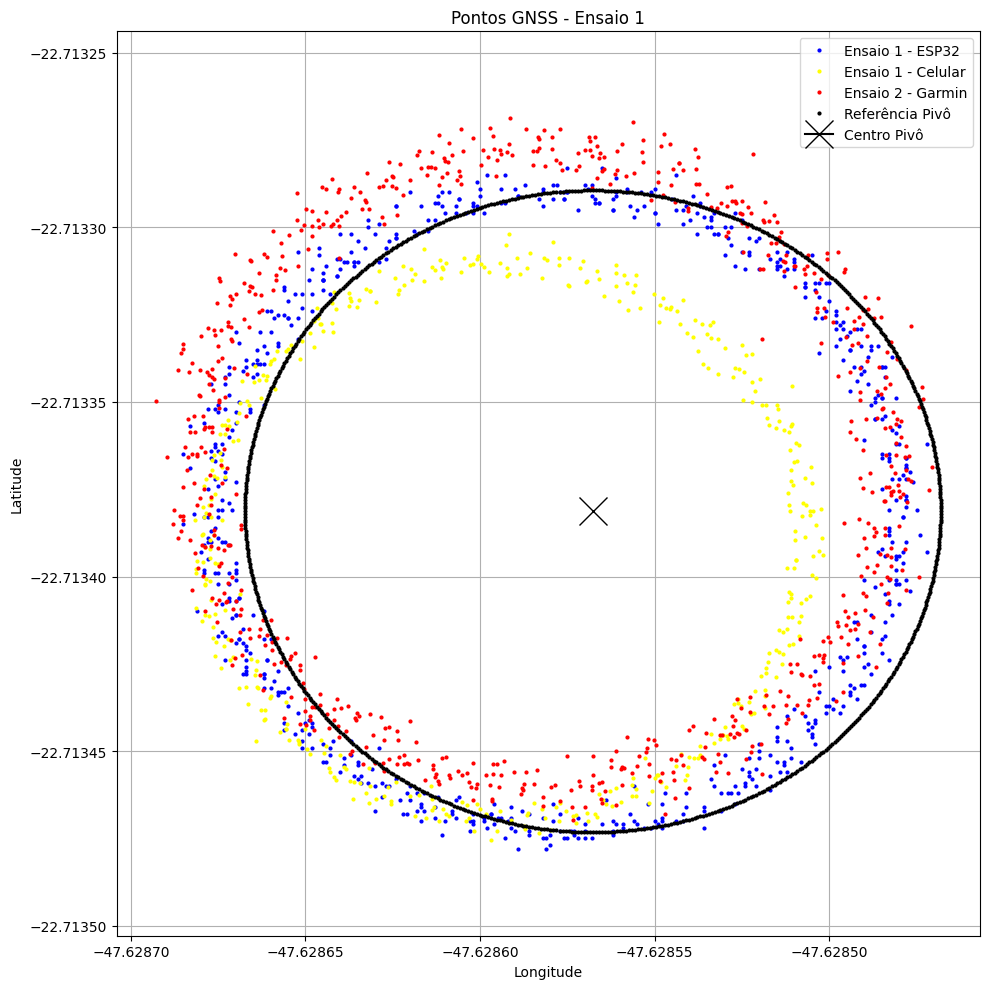

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot( laps['lap_1']["esp32"]["dataframe"]["longitude"], laps['lap_1']["esp32"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='blue', label="Ensaio 1 - ESP32")
ax.plot( laps['lap_1']["celular"]["dataframe"]["longitude"], laps['lap_1']["celular"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='yellow', label="Ensaio 1 - Celular")
ax.plot( laps['lap_1']["garmin"]["dataframe"]["longitude"], laps['lap_1']["garmin"]["dataframe"]["latitude"], marker='o', linestyle="", markersize=2, color='red', label="Ensaio 2 - Garmin")
ax.plot(df_pivot["longitude"], df_pivot["latitude"], marker='o', linestyle="", markersize=2, color='black', label="Referência Pivô")
ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=20, label="Centro Pivô")

ax.legend()

ax.set_title("Pontos GNSS - Ensaio 1")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.axis("equal")  # Mantém proporção correta
ax.ticklabel_format(useOffset=False)  # <--- ESSA LINHA REMOVE O OFFSET

plt.tight_layout()
plt.show()

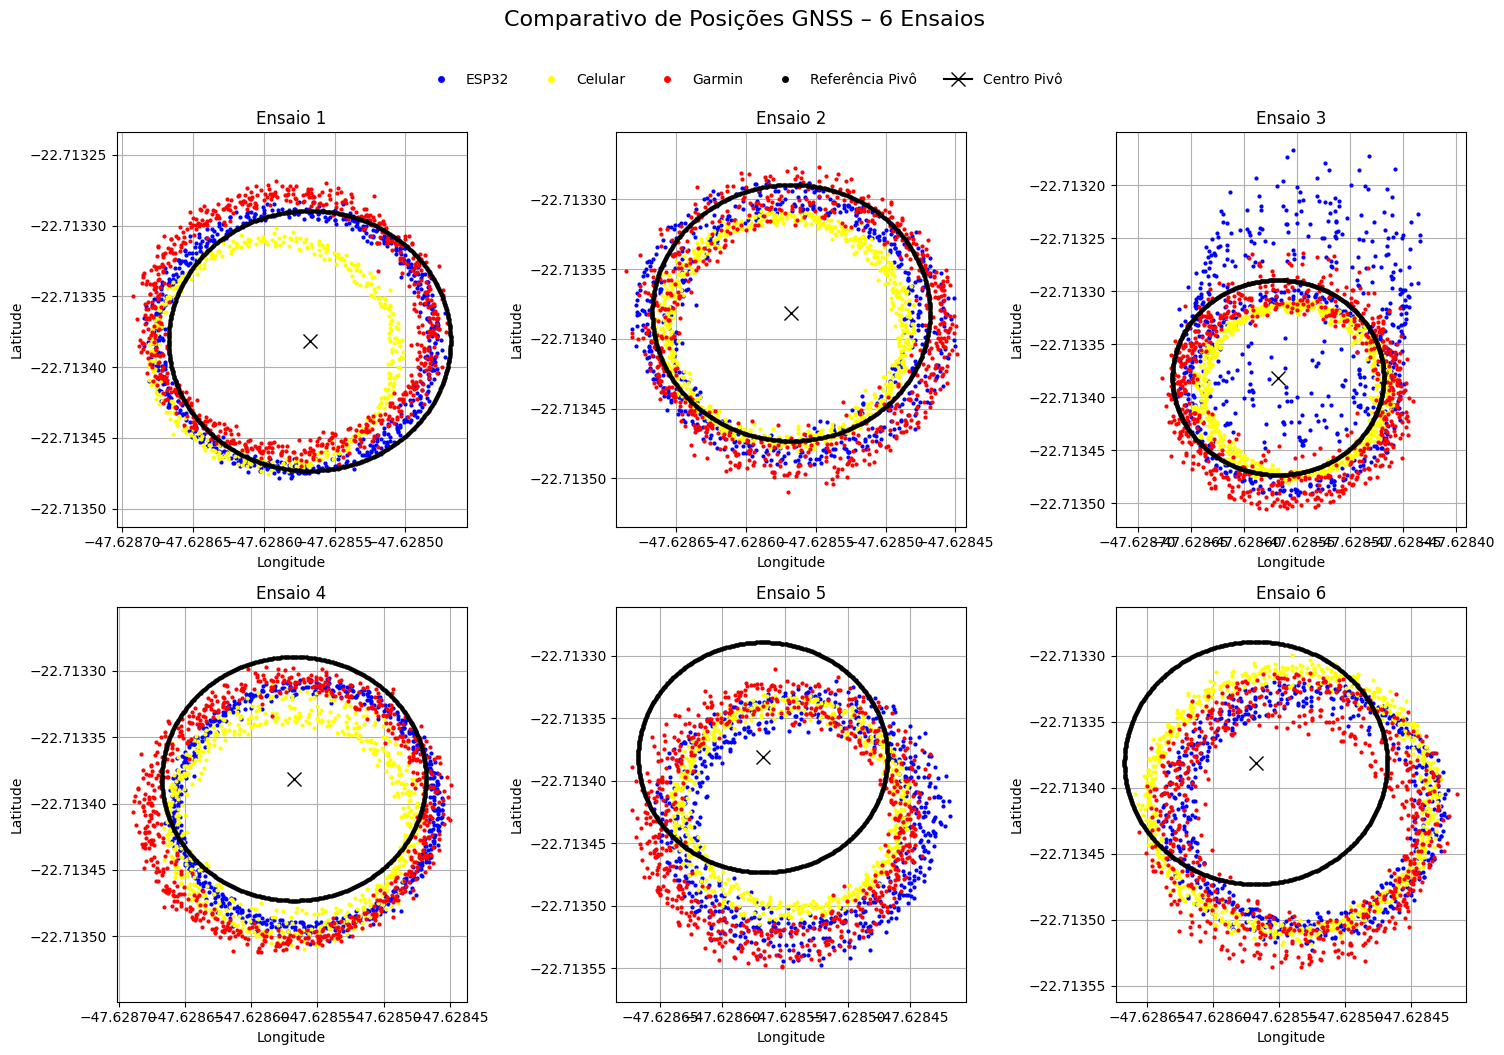

In [75]:
from matplotlib.lines import Line2D

# Configura o layout com 2 linhas e 3 colunas para 6 ensaios
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Faz um loop para iterar sobre os ensaios
for i in range(1, 7):  # De lap_1 a lap_6
    lap_name = f"lap_{i}"
    
    # Converte para um índice de subplot
    row = (i - 1) // 3
    col = (i - 1) % 3
    ax = axs[row, col]  # Seleciona o subplot correspondente
    
    # Títulos e labels para os subplots
    ax.set_title(f"Ensaio {i}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    

    ax.plot(laps[lap_name]["esp32"]["dataframe"]["longitude"], laps[lap_name]["esp32"]["dataframe"]["latitude"], 
                marker='o', linestyle="", markersize=2, color='blue', label="ESP32")
    
    
    ax.plot(laps[lap_name]["celular"]["dataframe"]["longitude"], laps[lap_name]["celular"]["dataframe"]["latitude"], 
                marker='o', linestyle="", markersize=2, color='yellow', label="Celular")
    
    
    ax.plot(laps[lap_name]["garmin"]["dataframe"]["longitude"], laps[lap_name]["garmin"]["dataframe"]["latitude"], 
                marker='o', linestyle="", markersize=2, color='red', label="Garmin")
    
    
    ax.plot(df_pivot["longitude"], df_pivot["latitude"], marker='o', linestyle="", markersize=2, color='black', label="Referência Pivô")
    ax.plot(pivot_long, pivot_lat, marker='x', color='black', markersize=10, label="Centro Pivô")
    

    # Ajusta o grid
    ax.grid(True)
    ax.axis("equal")  # Mantém a proporção correta
    ax.ticklabel_format(useOffset=False)  # Remove o offset das legendas


# Cria os handles da legenda global
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='ESP32', markerfacecolor='blue', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Celular', markerfacecolor='yellow', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Garmin', markerfacecolor='red', markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Referência Pivô', markerfacecolor='black', markersize=6),
    Line2D([0], [0], marker='x', color='black', label='Centro Pivô', markersize=10)
]


# Adiciona um título geral
fig.suptitle("Comparativo de Posições GNSS – 6 Ensaios", fontsize=16, y=1.05)

# Adiciona a legenda global acima dos subplots
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1),ncol=5, frameon=False)


# Ajuste no layout para que os subplots não se sobreponham
plt.tight_layout()
plt.show()


In [80]:
# Listas para armazenar os dados de erro
error_data_esp32 = []
error_data_cellular = []
error_data_garmin = []

# Lista de dispositivos e dicionário para mapear os dados
devices = ['esp32', 'celular', 'garmin']
data_by_device = {
    'esp32': error_data_esp32,
    'celular': error_data_cellular,
    'garmin': error_data_garmin
}

# Itera sobre as voltas e coleta as métricas dos dispositivos
for lap_name in laps.keys():
    for device in devices:
        error = laps[lap_name].get(device, {}).get('error_analysis')
        if error:
            data_by_device[device].append({
                'EMP': error['mean_euclidean_error_m'],
                'EM/L-O': error['mean_ew_error_m'],
                'EM/N-S': error['mean_ns_error_m'],
                'DP': error['std_euclidean_error_m'],
                'DP/L-O': error['std_ew_error_m'],
                'DP/N-S': error['std_ns_error_m'],
                '2σ': error['2sigma_m'],
                'CEP': error['cep_m'],
                'Max Error': error['max_euclidean_error_m'],
                'Min Error': error['min_euclidean_error_m'],
                'Number of Points': error['num_points']
            })

# Converte listas em DataFrames
df_esp32 = pd.DataFrame(error_data_esp32)
df_cellular = pd.DataFrame(error_data_cellular)
df_garmin = pd.DataFrame(error_data_garmin)

# Calcula médias
mean_esp32 = df_esp32.mean(numeric_only=True)
mean_cellular = df_cellular.mean(numeric_only=True)
mean_garmin = df_garmin.mean(numeric_only=True)

# Monta DataFrame final com as médias
df_mean = pd.DataFrame({
    'Device': ['ESP32', 'Celular', 'Garmin'],
    'EMP': [mean_esp32['EMP'], mean_cellular['EMP'], mean_garmin['EMP']],
    'EM/L-O': [mean_esp32['EM/L-O'], mean_cellular['EM/L-O'], mean_garmin['EM/L-O']],
    'EM/N-S': [mean_esp32['EM/N-S'], mean_cellular['EM/N-S'], mean_garmin['EM/N-S']],
    'DP': [mean_esp32['DP'], mean_cellular['DP'], mean_garmin['DP']],
    'DP/L-O': [mean_esp32['DP/L-O'], mean_cellular['DP/L-O'], mean_garmin['DP/L-O']],
    'DP/N-S': [mean_esp32['DP/N-S'], mean_cellular['DP/N-S'], mean_garmin['DP/N-S']],
    '2σ': [mean_esp32['2σ'], mean_cellular['2σ'], mean_garmin['2σ']],
    'CEP': [mean_esp32['CEP'], mean_cellular['CEP'], mean_garmin['CEP']],
    'Max Error': [mean_esp32['Max Error'], mean_cellular['Max Error'], mean_garmin['Max Error']],
    'Min Error': [mean_esp32['Min Error'], mean_cellular['Min Error'], mean_garmin['Min Error']],
    'Number of Points': [mean_esp32['Number of Points'], mean_cellular['Number of Points'], mean_garmin['Number of Points']]
})

# Exibe as médias finais
df_mean


,Device,EMP,EM/L-O,EM/N-S,DP,DP/L-O,DP/N-S,2σ,CEP,Max Error,Min Error,Number of Points
0,ESP32,2.299133,0.658799,-0.812738,1.431742,1.453855,1.651753,2.863484,2.609045,6.575962,0.015113,679.000000
1,Celular,2.115862,0.275680,-1.100768,1.319504,1.460813,1.447000,2.639007,2.427024,5.052287,0.015077,639.833333
2,Garmin,2.202490,0.337623,-1.177665,1.267600,1.341334,1.463375,2.535199,2.344008,5.579058,0.016103,720.500000
